In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE,SequentialFeatureSelector
from tqdm import tqdm
from imblearn.pipeline import Pipeline

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
rs = 0

In [2]:
processed_train_data = pd.read_csv("Processed_train_data.csv")
processed_test_data = pd.read_csv("Processed_test_data.csv")

In [3]:
processed_train_data.head()

,duration,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service,flag,src_bytes,dst_bytes,land,wrong_fragment,...,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_srv_serror_rate,class
0,0.0,0.0,1.0,0.0,0.273363,0.145284,0.009003,0.000000,0.0,0.0,...,0.00,0.00,0.588235,0.098039,0.17,0.03,0.17,0.00,0.00,0
1,0.0,0.0,0.0,1.0,0.389904,0.145284,0.002677,0.000000,0.0,0.0,...,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0
2,0.0,0.0,1.0,0.0,0.953923,0.989729,0.000000,0.000000,0.0,0.0,...,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1
3,0.0,0.0,1.0,0.0,0.056722,0.145284,0.004254,0.329867,0.0,0.0,...,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.01,0
4,0.0,0.0,1.0,0.0,0.056722,0.145284,0.003649,0.016993,0.0,0.0,...,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0


In [4]:
processed_train_data_corr = processed_train_data.corr()
processed_train_data_corr

,duration,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service,flag,src_bytes,dst_bytes,land,wrong_fragment,...,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_srv_serror_rate,class
duration,1.000000,-0.026685,-0.126197,0.172033,-0.024875,-0.027455,-0.010595,-0.000948,-0.001415,-0.008989,...,0.032963,-0.035889,0.042144,-0.098637,-0.103101,0.271852,0.221037,-0.027987,-0.060246,-0.057015
protocol_type_icmp,-0.026685,1.000000,-0.559197,-0.099729,0.233540,-0.218635,-0.023752,-0.101339,-0.003845,0.000604,...,-0.019567,0.340639,-0.195707,-0.010787,0.156807,-0.088215,0.576785,0.483155,-0.171064,0.200445
protocol_type_tcp,-0.126197,-0.559197,1.000000,-0.769134,-0.010839,0.390981,0.059445,0.173631,0.006876,-0.188367,...,0.011799,-0.174979,-0.010342,-0.106302,-0.207503,-0.027979,-0.493802,-0.225143,0.305910,0.055233
protocol_type_udp,0.172033,-0.099729,-0.769134,1.000000,-0.167023,-0.300716,-0.053036,-0.130272,-0.005289,0.225613,...,0.000922,-0.052581,0.163280,0.135900,0.128167,0.101584,0.148032,-0.102237,-0.235286,-0.220810
service,-0.024875,0.233540,-0.010839,-0.167023,1.000000,0.693833,-0.123152,-0.335716,0.007357,0.101938,...,0.179723,-0.146869,0.356693,-0.749486,-0.726318,0.225503,0.126824,0.080278,0.611202,0.863797
flag,-0.027455,-0.218635,0.390981,-0.300716,0.693833,1.000000,-0.114055,-0.299261,0.019236,-0.073648,...,0.187326,-0.263952,0.422650,-0.685919,-0.751658,0.177026,-0.259915,-0.152276,0.843170,0.772062
src_bytes,-0.010595,-0.023752,0.059445,-0.053036,-0.123152,-0.114055,1.000000,0.206159,-0.002244,-0.011908,...,-0.037939,0.021774,-0.058692,0.027308,0.099403,-0.044782,-0.011672,-0.034766,-0.097513,0.032445
dst_bytes,-0.000948,-0.101339,0.173631,-0.130272,-0.335716,-0.299261,0.206159,1.000000,-0.005374,-0.034135,...,-0.122054,0.017184,-0.222395,0.371105,0.355464,-0.146216,-0.087215,-0.020915,-0.232907,-0.304654
land,-0.001415,-0.003845,0.006876,-0.005289,0.007357,0.019236,-0.002244,-0.005374,1.000000,-0.001295,...,-0.001647,0.038301,-0.025973,-0.014425,0.011687,-0.004414,0.035352,0.070849,0.012123,0.007136
wrong_fragment,-0.008989,0.000604,-0.188367,0.225613,0.101938,-0.073648,-0.011908,-0.034135,-0.001295,1.000000,...,-0.027377,-0.026846,0.041086,-0.046316,-0.049744,0.064102,0.040439,-0.016614,-0.057623,0.096211


In [5]:
processed_train_data_trX = processed_train_data.drop(columns=["class"],axis=1)
processed_train_data_trY = processed_train_data["class"]

In [6]:
processed_test_data_X = processed_test_data.drop(columns=["class"],axis=1)
processed_test_data_Y = processed_test_data["class"]

In [7]:
from imblearn.over_sampling import ADASYN, SMOTE
adasyn = ADASYN(random_state=rs)
smote = SMOTE(random_state=rs)

processed_smote_train_data_trX, processed_smote_train_data_trY = smote.fit_resample(processed_train_data_trX, processed_train_data_trY)

In [8]:
processed_adasyn_train_data_trX, processed_adasyn_train_data_trY = adasyn.fit_resample(processed_train_data_trX, processed_train_data_trY)

In [9]:
processed_smote_train_data = processed_smote_train_data_trX
processed_smote_train_data["class"] = processed_smote_train_data_trY

In [10]:
processed_smote_train_data["class"].value_counts()

0    64928
1    64928
Name: class, dtype: int64

In [11]:
processed_smote_train_data.to_csv("processed_smote_train_data.csv",index=False)

In [12]:
processed_adasyn_train_data = processed_adasyn_train_data_trX
processed_adasyn_train_data["class"] = processed_adasyn_train_data_trY

In [13]:
processed_adasyn_train_data["class"].value_counts()

0    64928
1    64813
Name: class, dtype: int64

In [14]:
processed_train_data["class"].value_counts()

0    64928
1    57709
Name: class, dtype: int64

In [15]:
processed_adasyn_train_data.to_csv("processed_adasyn_train_data.csv",index=False)

In [16]:
processed_smote_train_data_trX = processed_smote_train_data.drop(columns=["class"],axis=1)
processed_smote_train_data_trY = processed_smote_train_data["class"]

processed_adasyn_train_data_trX = processed_adasyn_train_data.drop(columns=["class"],axis=1)
processed_adasyn_train_data_trY = processed_adasyn_train_data["class"]

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix,f1_score,precision_score,recall_score,RocCurveDisplay,PrecisionRecallDisplay

In [20]:
#Function to obtain different metrics based on predicted class labels
def print_metrics(y_test,y_pred,name):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title("Confusion Matrix Obtained")
    plt.show();
    accuracy_value = round(accuracy_score(y_test,y_pred),4)
    f1_value = round(f1_score(y_test,y_pred,labels=np.unique(y_pred)),4) 
    prec = round(precision_score(y_test,y_pred,labels=np.unique(y_pred)),4)
    rec = round(recall_score(y_test,y_pred,labels=np.unique(y_pred)),4)
    print("Accuarcy value obtained is ",accuracy_value)
    print("F1-score obtained is ",f1_value)
    print("Precision obtained is ",prec)
    print("Recall obtained is ",rec)
    roc_display = RocCurveDisplay.from_predictions(y_test,y_pred,name=name)
    _ = roc_display.ax_.set_title("ROC curve")
    pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name=name)
    _ = pr_display.ax_.set_title("Precision-Recall curve")
    return [accuracy_value,f1_value,prec,rec]

In [21]:
logreg_results_table = []

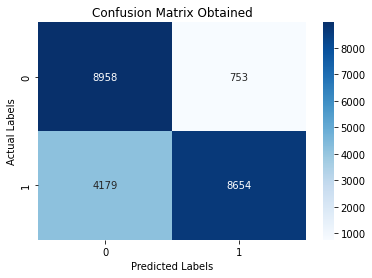

Accuarcy value obtained is  0.7812
F1-score obtained is  0.7782
Precision obtained is  0.92
Recall obtained is  0.6744


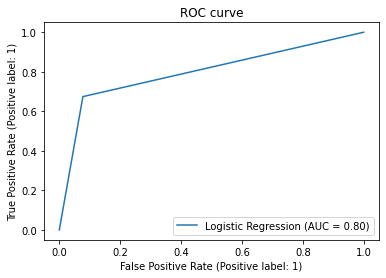

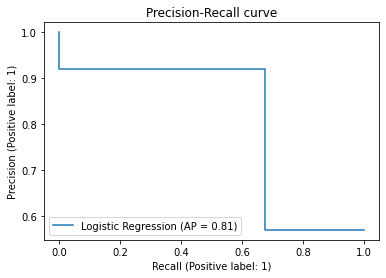

In [22]:
logreg = LogisticRegression(random_state=rs)
logreg.fit(processed_train_data_trX,processed_train_data_trY)
logreg_yPred = logreg.predict(processed_test_data_X)
#Performance Metrics obtained using Logistic Regression
logreg_list = ["Logistic Regression"]
logreg_list.extend(print_metrics(processed_test_data_Y, logreg_yPred,"Logistic Regression"))
logreg_results_table.append(logreg_list)

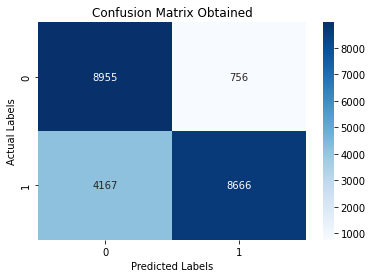

Accuarcy value obtained is  0.7816
F1-score obtained is  0.7788
Precision obtained is  0.9198
Recall obtained is  0.6753


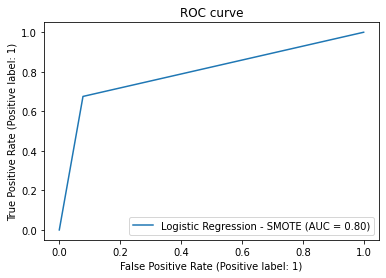

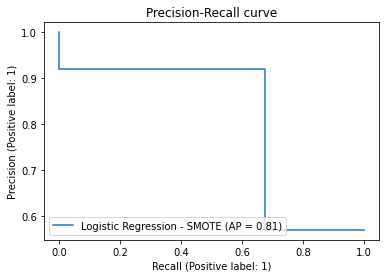

In [23]:
logreg_smote = LogisticRegression(random_state=rs)
logreg_smote.fit(processed_smote_train_data_trX,processed_smote_train_data_trY)
logreg_smote_yPred = logreg_smote.predict(processed_test_data_X)
#Performance Metrics obtained using Logistic Regression
logreg_list = ["Logistic Regression - SMOTE"]
logreg_list.extend(print_metrics(processed_test_data_Y, logreg_smote_yPred,"Logistic Regression - SMOTE"))
logreg_results_table.append(logreg_list)

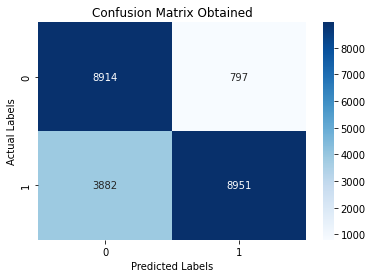

Accuarcy value obtained is  0.7925
F1-score obtained is  0.7928
Precision obtained is  0.9182
Recall obtained is  0.6975


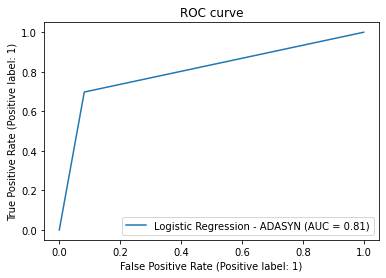

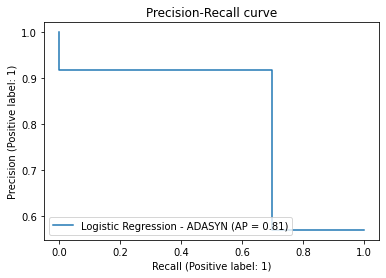

In [24]:
logreg_adasyn = LogisticRegression(random_state=rs)
logreg_adasyn.fit(processed_adasyn_train_data_trX,processed_adasyn_train_data_trY)
logreg_adasyn_yPred = logreg_adasyn.predict(processed_test_data_X)
#Performance Metrics obtained using Logistic Regression
logreg_list = ["Logistic Regression - ADASYN"]
logreg_list.extend(print_metrics(processed_test_data_Y, logreg_adasyn_yPred,"Logistic Regression - ADASYN"))
logreg_results_table.append(logreg_list)

In [25]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [27]:
#Hyperparameter Tuning of Logistic Regression
from sklearn.model_selection import GridSearchCV
log_reg = LogisticRegression(random_state=rs)
params = [    
    {'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear','sag','saga'],
    'max_iter' : [1000,2500, 5000]
   }
]

grid_search = GridSearchCV(estimator=log_reg,
                           param_grid=params,
                           cv=5, verbose=10, scoring = "f1")
grid_search.fit(processed_train_data_trX, processed_train_data_trY)
print(grid_search.best_estimator_)
print(grid_search.best_estimator_.get_params())

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[CV 1/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 1/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.939 total time=   0.4s
[CV 2/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 2/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.940 total time=   0.4s
[CV 3/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 3/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.940 total time=   0.4s
[CV 4/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 4/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.941 total time=   0.4s
[CV 5/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 5/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.944 total time=   0

[CV 1/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.939 total time=   0.4s
[CV 2/5; 10/540] START C=0.0001, max_iter=2500, penalty=l1, solver=liblinear....
[CV 2/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.940 total time=   0.4s
[CV 3/5; 10/540] START C=0.0001, max_iter=2500, penalty=l1, solver=liblinear....
[CV 3/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.940 total time=   0.4s
[CV 4/5; 10/540] START C=0.0001, max_iter=2500, penalty=l1, solver=liblinear....
[CV 4/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.941 total time=   0.4s
[CV 5/5; 10/540] START C=0.0001, max_iter=2500, penalty=l1, solver=liblinear....
[CV 5/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.944 total time=   0.4s
[CV 1/5; 11/540] START C=0.0001, max_iter=2500, penalty=l1, solver=sag..........
[CV 1/5; 11/540] END C=0.0001, max_iter=2500, penalty=l

[CV 1/5; 19/540] END C=0.0001, max_iter=5000, penalty=l1, solver=liblinear;, score=0.939 total time=   0.4s
[CV 2/5; 19/540] START C=0.0001, max_iter=5000, penalty=l1, solver=liblinear....
[CV 2/5; 19/540] END C=0.0001, max_iter=5000, penalty=l1, solver=liblinear;, score=0.940 total time=   0.4s
[CV 3/5; 19/540] START C=0.0001, max_iter=5000, penalty=l1, solver=liblinear....
[CV 3/5; 19/540] END C=0.0001, max_iter=5000, penalty=l1, solver=liblinear;, score=0.940 total time=   0.4s
[CV 4/5; 19/540] START C=0.0001, max_iter=5000, penalty=l1, solver=liblinear....
[CV 4/5; 19/540] END C=0.0001, max_iter=5000, penalty=l1, solver=liblinear;, score=0.941 total time=   0.4s
[CV 5/5; 19/540] START C=0.0001, max_iter=5000, penalty=l1, solver=liblinear....
[CV 5/5; 19/540] END C=0.0001, max_iter=5000, penalty=l1, solver=liblinear;, score=0.944 total time=   0.4s
[CV 1/5; 20/540] START C=0.0001, max_iter=5000, penalty=l1, solver=sag..........
[CV 1/5; 20/540] END C=0.0001, max_iter=5000, penalty=l

[CV 1/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.940 total time=   0.5s
[CV 2/5; 28/540] START C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear
[CV 2/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.941 total time=   0.5s
[CV 3/5; 28/540] START C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear
[CV 3/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.942 total time=   0.5s
[CV 4/5; 28/540] START C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear
[CV 4/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.943 total time=   0.5s
[CV 5/5; 28/540] START C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear
[CV 5/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.943 total time=   0.5s
[CV 1/5;

[CV 3/5; 36/540] START C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga
[CV 3/5; 36/540] END C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 36/540] START C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga
[CV 4/5; 36/540] END C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 36/540] START C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga
[CV 5/5; 36/540] END C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 37/540] START C=0.00026366508987303583, max_iter=2500, penalty=l1, solver=liblinear
[CV 1/5; 37/540] END C=0.00026366508987303583, max_iter=2500, penalty=l1, solver=liblinear;, score=0.940 total time=   0.5s
[CV 2/5; 37/540] START C=0.00026366508987303583, max_iter=2500, penalty=l1, solver=liblinear
[CV 2/5; 37/540] END C=0.00

[CV 3/5; 44/540] END C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 44/540] START C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 44/540] END C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 44/540] START C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 44/540] END C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 45/540] START C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 45/540] END C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 45/540] START C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=saga
[CV 2/5; 45/540] END C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0

[CV 4/5; 52/540] END C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 52/540] START C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=liblinear
[CV 5/5; 52/540] END C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 53/540] START C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag
[CV 1/5; 53/540] END C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 53/540] START C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 53/540] END C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 53/540] START C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 53/540] END C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan t

[CV 3/5; 60/540] END C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=saga;, score=0.961 total time=   2.7s
[CV 4/5; 60/540] START C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=saga
[CV 4/5; 60/540] END C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=saga;, score=0.961 total time=   2.5s
[CV 5/5; 60/540] START C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=saga
[CV 5/5; 60/540] END C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=saga;, score=0.962 total time=   2.4s
[CV 1/5; 61/540] START C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=liblinear
[CV 1/5; 61/540] END C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 61/540] START C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=liblinear
[CV 2/5; 61/540] END C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 61/54

[CV 2/5; 68/540] END C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=sag;, score=0.960 total time=   1.5s
[CV 3/5; 68/540] START C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=sag
[CV 3/5; 68/540] END C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=sag;, score=0.961 total time=   1.7s
[CV 4/5; 68/540] START C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=sag
[CV 4/5; 68/540] END C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=sag;, score=0.961 total time=   1.4s
[CV 5/5; 68/540] START C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=sag
[CV 5/5; 68/540] END C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=sag;, score=0.962 total time=   1.5s
[CV 1/5; 69/540] START C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=saga
[CV 1/5; 69/540] END C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=saga;, score=0.959 total time=   2.5s
[CV 2/5; 69/540] START C=0.0006951927961775605, max_iter=2500, penalt

[CV 1/5; 76/540] END C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=liblinear;, score=0.956 total time=   0.5s
[CV 2/5; 76/540] START C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=liblinear
[CV 2/5; 76/540] END C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=liblinear;, score=0.957 total time=   0.6s
[CV 3/5; 76/540] START C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=liblinear
[CV 3/5; 76/540] END C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=liblinear;, score=0.958 total time=   0.6s
[CV 4/5; 76/540] START C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=liblinear
[CV 4/5; 76/540] END C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=liblinear;, score=0.958 total time=   0.6s
[CV 5/5; 76/540] START C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=liblinear
[CV 5/5; 76/540] END C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=liblinear;, score=0.959 total time=   0.6s
[CV 1/5; 77/540] 

[CV 5/5; 83/540] START C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=sag
[CV 5/5; 83/540] END C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 84/540] START C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga
[CV 1/5; 84/540] END C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga;, score=0.961 total time=   3.0s
[CV 2/5; 84/540] START C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga
[CV 2/5; 84/540] END C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga;, score=0.959 total time=   3.0s
[CV 3/5; 84/540] START C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga
[CV 3/5; 84/540] END C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga;, score=0.962 total time=   3.0s
[CV 4/5; 84/540] START C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga
[CV 4/5; 84/540] END C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga;, score=0.96

[CV 4/5; 91/540] END C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=liblinear;, score=0.957 total time=   0.8s
[CV 5/5; 91/540] START C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=liblinear
[CV 5/5; 91/540] END C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=liblinear;, score=0.957 total time=   0.8s
[CV 1/5; 92/540] START C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=sag
[CV 1/5; 92/540] END C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 92/540] START C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=sag
[CV 2/5; 92/540] END C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 92/540] START C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=sag
[CV 3/5; 92/540] END C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 92/540] START C=0.0018329807108324356, max_iter=25

[CV 1/5; 100/540] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=liblinear;, score=0.953 total time=   0.8s
[CV 2/5; 100/540] START C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=liblinear
[CV 2/5; 100/540] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=liblinear;, score=0.954 total time=   0.9s
[CV 3/5; 100/540] START C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=liblinear
[CV 3/5; 100/540] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=liblinear;, score=0.956 total time=   0.6s
[CV 4/5; 100/540] START C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=liblinear
[CV 4/5; 100/540] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=liblinear;, score=0.957 total time=   0.8s
[CV 5/5; 100/540] START C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=liblinear
[CV 5/5; 100/540] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=liblinear;, score=0.957 total time=   0.8s
[CV 1/5;

[CV 3/5; 108/540] START C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=saga
[CV 3/5; 108/540] END C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 108/540] START C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=saga
[CV 4/5; 108/540] END C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 108/540] START C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=saga
[CV 5/5; 108/540] END C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 109/540] START C=0.004832930238571752, max_iter=1000, penalty=l1, solver=liblinear
[CV 1/5; 109/540] END C=0.004832930238571752, max_iter=1000, penalty=l1, solver=liblinear;, score=0.972 total time=   1.6s
[CV 2/5; 109/540] START C=0.004832930238571752, max_iter=1000, penalty=l1, solver=liblinear
[CV 2/5; 109/540] END C=0.0048

[CV 3/5; 116/540] END C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 116/540] START C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 116/540] END C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 116/540] START C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 116/540] END C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 117/540] START C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 117/540] END C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 117/540] START C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/5; 117/540] END C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3

[CV 5/5; 124/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=liblinear
[CV 5/5; 124/540] END C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 125/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag
[CV 1/5; 125/540] END C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 125/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 125/540] END C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 125/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 125/540] END C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 125/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 125/540] END C=0.

[CV 4/5; 132/540] END C=0.004832930238571752, max_iter=5000, penalty=l2, solver=saga;, score=0.969 total time=   2.1s
[CV 5/5; 132/540] START C=0.004832930238571752, max_iter=5000, penalty=l2, solver=saga
[CV 5/5; 132/540] END C=0.004832930238571752, max_iter=5000, penalty=l2, solver=saga;, score=0.969 total time=   2.4s
[CV 1/5; 133/540] START C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=liblinear
[CV 1/5; 133/540] END C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 133/540] START C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=liblinear
[CV 2/5; 133/540] END C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 133/540] START C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=liblinear
[CV 3/5; 133/540] END C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=liblinear;, score=nan total tim

[CV 3/5; 140/540] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=sag;, score=0.972 total time=   1.8s
[CV 4/5; 140/540] START C=0.012742749857031334, max_iter=1000, penalty=l2, solver=sag
[CV 4/5; 140/540] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=sag;, score=0.972 total time=   1.8s
[CV 5/5; 140/540] START C=0.012742749857031334, max_iter=1000, penalty=l2, solver=sag
[CV 5/5; 140/540] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=sag;, score=0.973 total time=   1.7s
[CV 1/5; 141/540] START C=0.012742749857031334, max_iter=1000, penalty=l2, solver=saga
[CV 1/5; 141/540] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=saga;, score=0.971 total time=   2.4s
[CV 2/5; 141/540] START C=0.012742749857031334, max_iter=1000, penalty=l2, solver=saga
[CV 2/5; 141/540] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=saga;, score=0.970 total time=   2.2s
[CV 3/5; 141/540] START C=0.012742749857031334, max_iter=1000, pena

[CV 2/5; 148/540] END C=0.012742749857031334, max_iter=2500, penalty=l2, solver=liblinear;, score=0.970 total time=   0.8s
[CV 3/5; 148/540] START C=0.012742749857031334, max_iter=2500, penalty=l2, solver=liblinear
[CV 3/5; 148/540] END C=0.012742749857031334, max_iter=2500, penalty=l2, solver=liblinear;, score=0.972 total time=   0.8s
[CV 4/5; 148/540] START C=0.012742749857031334, max_iter=2500, penalty=l2, solver=liblinear
[CV 4/5; 148/540] END C=0.012742749857031334, max_iter=2500, penalty=l2, solver=liblinear;, score=0.972 total time=   0.7s
[CV 5/5; 148/540] START C=0.012742749857031334, max_iter=2500, penalty=l2, solver=liblinear
[CV 5/5; 148/540] END C=0.012742749857031334, max_iter=2500, penalty=l2, solver=liblinear;, score=0.973 total time=   0.7s
[CV 1/5; 149/540] START C=0.012742749857031334, max_iter=2500, penalty=l2, solver=sag
[CV 1/5; 149/540] END C=0.012742749857031334, max_iter=2500, penalty=l2, solver=sag;, score=0.971 total time=   1.6s
[CV 2/5; 149/540] START C=0.0

[CV 1/5; 156/540] END C=0.012742749857031334, max_iter=5000, penalty=l1, solver=saga;, score=0.976 total time=   2.8s
[CV 2/5; 156/540] START C=0.012742749857031334, max_iter=5000, penalty=l1, solver=saga
[CV 2/5; 156/540] END C=0.012742749857031334, max_iter=5000, penalty=l1, solver=saga;, score=0.976 total time=   2.7s
[CV 3/5; 156/540] START C=0.012742749857031334, max_iter=5000, penalty=l1, solver=saga
[CV 3/5; 156/540] END C=0.012742749857031334, max_iter=5000, penalty=l1, solver=saga;, score=0.977 total time=   2.6s
[CV 4/5; 156/540] START C=0.012742749857031334, max_iter=5000, penalty=l1, solver=saga
[CV 4/5; 156/540] END C=0.012742749857031334, max_iter=5000, penalty=l1, solver=saga;, score=0.977 total time=   2.8s
[CV 5/5; 156/540] START C=0.012742749857031334, max_iter=5000, penalty=l1, solver=saga
[CV 5/5; 156/540] END C=0.012742749857031334, max_iter=5000, penalty=l1, solver=saga;, score=0.978 total time=   2.9s
[CV 1/5; 157/540] START C=0.012742749857031334, max_iter=5000,

[CV 5/5; 163/540] END C=0.03359818286283781, max_iter=1000, penalty=l1, solver=liblinear;, score=0.979 total time=   2.0s
[CV 1/5; 164/540] START C=0.03359818286283781, max_iter=1000, penalty=l1, solver=sag
[CV 1/5; 164/540] END C=0.03359818286283781, max_iter=1000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 164/540] START C=0.03359818286283781, max_iter=1000, penalty=l1, solver=sag
[CV 2/5; 164/540] END C=0.03359818286283781, max_iter=1000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 164/540] START C=0.03359818286283781, max_iter=1000, penalty=l1, solver=sag
[CV 3/5; 164/540] END C=0.03359818286283781, max_iter=1000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 164/540] START C=0.03359818286283781, max_iter=1000, penalty=l1, solver=sag
[CV 4/5; 164/540] END C=0.03359818286283781, max_iter=1000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 164/540] START C=0.03359818286283781, max_iter=1000, penalty=l1, solver=s

[CV 1/5; 172/540] END C=0.03359818286283781, max_iter=2500, penalty=l1, solver=liblinear;, score=0.978 total time=   2.6s
[CV 2/5; 172/540] START C=0.03359818286283781, max_iter=2500, penalty=l1, solver=liblinear
[CV 2/5; 172/540] END C=0.03359818286283781, max_iter=2500, penalty=l1, solver=liblinear;, score=0.978 total time=   2.2s
[CV 3/5; 172/540] START C=0.03359818286283781, max_iter=2500, penalty=l1, solver=liblinear
[CV 3/5; 172/540] END C=0.03359818286283781, max_iter=2500, penalty=l1, solver=liblinear;, score=0.978 total time=   2.1s
[CV 4/5; 172/540] START C=0.03359818286283781, max_iter=2500, penalty=l1, solver=liblinear
[CV 4/5; 172/540] END C=0.03359818286283781, max_iter=2500, penalty=l1, solver=liblinear;, score=0.978 total time=   2.5s
[CV 5/5; 172/540] START C=0.03359818286283781, max_iter=2500, penalty=l1, solver=liblinear
[CV 5/5; 172/540] END C=0.03359818286283781, max_iter=2500, penalty=l1, solver=liblinear;, score=0.979 total time=   2.0s
[CV 1/5; 173/540] START C=

[CV 3/5; 180/540] START C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=saga
[CV 3/5; 180/540] END C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 180/540] START C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=saga
[CV 4/5; 180/540] END C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 180/540] START C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=saga
[CV 5/5; 180/540] END C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 181/540] START C=0.03359818286283781, max_iter=5000, penalty=l1, solver=liblinear
[CV 1/5; 181/540] END C=0.03359818286283781, max_iter=5000, penalty=l1, solver=liblinear;, score=0.978 total time=   2.7s
[CV 2/5; 181/540] START C=0.03359818286283781, max_iter=5000, penalty=l1, solver=liblinear
[CV 2/5; 181/540] END C=0.03359818286283781, 

[CV 4/5; 188/540] START C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 188/540] END C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 188/540] START C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 188/540] END C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 189/540] START C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 189/540] END C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 189/540] START C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=saga
[CV 2/5; 189/540] END C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 189/540] START C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=saga
[CV 3/5; 189/540] END C=0.0335981828628378

[CV 4/5; 196/540] END C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5; 196/540] START C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=liblinear
[CV 5/5; 196/540] END C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 197/540] START C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=sag
[CV 1/5; 197/540] END C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 197/540] START C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 197/540] END C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 197/540] START C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 197/540] END C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s


[CV 4/5; 204/540] END C=0.08858667904100823, max_iter=2500, penalty=l2, solver=saga;, score=0.979 total time=   2.1s
[CV 5/5; 204/540] START C=0.08858667904100823, max_iter=2500, penalty=l2, solver=saga
[CV 5/5; 204/540] END C=0.08858667904100823, max_iter=2500, penalty=l2, solver=saga;, score=0.980 total time=   2.1s
[CV 1/5; 205/540] START C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=liblinear
[CV 1/5; 205/540] END C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 205/540] START C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=liblinear
[CV 2/5; 205/540] END C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 205/540] START C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=liblinear
[CV 3/5; 205/540] END C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s

[CV 3/5; 212/540] END C=0.08858667904100823, max_iter=5000, penalty=l2, solver=sag;, score=0.978 total time=   2.5s
[CV 4/5; 212/540] START C=0.08858667904100823, max_iter=5000, penalty=l2, solver=sag
[CV 4/5; 212/540] END C=0.08858667904100823, max_iter=5000, penalty=l2, solver=sag;, score=0.979 total time=   2.5s
[CV 5/5; 212/540] START C=0.08858667904100823, max_iter=5000, penalty=l2, solver=sag
[CV 5/5; 212/540] END C=0.08858667904100823, max_iter=5000, penalty=l2, solver=sag;, score=0.980 total time=   2.5s
[CV 1/5; 213/540] START C=0.08858667904100823, max_iter=5000, penalty=l2, solver=saga
[CV 1/5; 213/540] END C=0.08858667904100823, max_iter=5000, penalty=l2, solver=saga;, score=0.979 total time=   2.5s
[CV 2/5; 213/540] START C=0.08858667904100823, max_iter=5000, penalty=l2, solver=saga
[CV 2/5; 213/540] END C=0.08858667904100823, max_iter=5000, penalty=l2, solver=saga;, score=0.978 total time=   2.2s
[CV 3/5; 213/540] START C=0.08858667904100823, max_iter=5000, penalty=l2, so

[CV 2/5; 220/540] END C=0.23357214690901212, max_iter=1000, penalty=l2, solver=liblinear;, score=0.978 total time=   1.4s
[CV 3/5; 220/540] START C=0.23357214690901212, max_iter=1000, penalty=l2, solver=liblinear
[CV 3/5; 220/540] END C=0.23357214690901212, max_iter=1000, penalty=l2, solver=liblinear;, score=0.978 total time=   1.2s
[CV 4/5; 220/540] START C=0.23357214690901212, max_iter=1000, penalty=l2, solver=liblinear
[CV 4/5; 220/540] END C=0.23357214690901212, max_iter=1000, penalty=l2, solver=liblinear;, score=0.979 total time=   1.2s
[CV 5/5; 220/540] START C=0.23357214690901212, max_iter=1000, penalty=l2, solver=liblinear
[CV 5/5; 220/540] END C=0.23357214690901212, max_iter=1000, penalty=l2, solver=liblinear;, score=0.980 total time=   1.1s
[CV 1/5; 221/540] START C=0.23357214690901212, max_iter=1000, penalty=l2, solver=sag
[CV 1/5; 221/540] END C=0.23357214690901212, max_iter=1000, penalty=l2, solver=sag;, score=0.979 total time=   2.9s
[CV 2/5; 221/540] START C=0.2335721469

[CV 1/5; 228/540] END C=0.23357214690901212, max_iter=2500, penalty=l1, solver=saga;, score=0.979 total time=  10.7s
[CV 2/5; 228/540] START C=0.23357214690901212, max_iter=2500, penalty=l1, solver=saga
[CV 2/5; 228/540] END C=0.23357214690901212, max_iter=2500, penalty=l1, solver=saga;, score=0.979 total time=  15.9s
[CV 3/5; 228/540] START C=0.23357214690901212, max_iter=2500, penalty=l1, solver=saga
[CV 3/5; 228/540] END C=0.23357214690901212, max_iter=2500, penalty=l1, solver=saga;, score=0.978 total time=  15.1s
[CV 4/5; 228/540] START C=0.23357214690901212, max_iter=2500, penalty=l1, solver=saga
[CV 4/5; 228/540] END C=0.23357214690901212, max_iter=2500, penalty=l1, solver=saga;, score=0.979 total time=   9.0s
[CV 5/5; 228/540] START C=0.23357214690901212, max_iter=2500, penalty=l1, solver=saga
[CV 5/5; 228/540] END C=0.23357214690901212, max_iter=2500, penalty=l1, solver=saga;, score=0.981 total time=   9.0s
[CV 1/5; 229/540] START C=0.23357214690901212, max_iter=2500, penalty=l

[CV 5/5; 235/540] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear;, score=0.981 total time=  11.1s
[CV 1/5; 236/540] START C=0.23357214690901212, max_iter=5000, penalty=l1, solver=sag
[CV 1/5; 236/540] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 236/540] START C=0.23357214690901212, max_iter=5000, penalty=l1, solver=sag
[CV 2/5; 236/540] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 236/540] START C=0.23357214690901212, max_iter=5000, penalty=l1, solver=sag
[CV 3/5; 236/540] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 236/540] START C=0.23357214690901212, max_iter=5000, penalty=l1, solver=sag
[CV 4/5; 236/540] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 236/540] START C=0.23357214690901212, max_iter=5000, penalty=l1, solver=s

[CV 1/5; 244/540] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear;, score=0.979 total time=   2.6s
[CV 2/5; 244/540] START C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear
[CV 2/5; 244/540] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear;, score=0.980 total time=   2.6s
[CV 3/5; 244/540] START C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear
[CV 3/5; 244/540] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear;, score=0.979 total time=   2.5s
[CV 4/5; 244/540] START C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear
[CV 4/5; 244/540] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear;, score=0.979 total time=  11.4s
[CV 5/5; 244/540] START C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear
[CV 5/5; 244/540] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear;, score=0.981 total time=  11.4s
[CV 1/5; 245/540] START C=0.615848211066026,

[CV 3/5; 252/540] START C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga
[CV 3/5; 252/540] END C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 252/540] START C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga
[CV 4/5; 252/540] END C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 252/540] START C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga
[CV 5/5; 252/540] END C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 253/540] START C=0.615848211066026, max_iter=2500, penalty=l1, solver=liblinear
[CV 1/5; 253/540] END C=0.615848211066026, max_iter=2500, penalty=l1, solver=liblinear;, score=0.979 total time=   2.6s
[CV 2/5; 253/540] START C=0.615848211066026, max_iter=2500, penalty=l1, solver=liblinear
[CV 2/5; 253/540] END C=0.615848211066026, max_iter=2500, penal

[CV 4/5; 260/540] START C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 260/540] END C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 260/540] START C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 260/540] END C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 261/540] START C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 261/540] END C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 261/540] START C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=saga
[CV 2/5; 261/540] END C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 261/540] START C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=saga
[CV 3/5; 261/540] END C=0.615848211066026, max_iter=2500, pe

[CV 3/5; 269/540] START C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 269/540] END C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 269/540] START C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 269/540] END C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 269/540] START C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 269/540] END C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 270/540] START C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 270/540] END C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 270/540] START C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=saga
[CV 2/5; 270/540] END C=0.615848211066026, max_iter=5000, pena

[CV 3/5; 278/540] START C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 278/540] END C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 278/540] START C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 278/540] END C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 278/540] START C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 278/540] END C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 279/540] START C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 279/540] END C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 279/540] START C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/5; 279/540] END C=1.623776739188721, max_iter=1000, pena

[CV 3/5; 287/540] START C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 287/540] END C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 287/540] START C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 287/540] END C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 287/540] START C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 287/540] END C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 288/540] START C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 288/540] END C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 288/540] START C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=saga
[CV 2/5; 288/540] END C=1.623776739188721, max_iter=2500, pena

[CV 2/5; 296/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 296/540] END C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 296/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 296/540] END C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 296/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 296/540] END C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 296/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 296/540] END C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 297/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 297/540] END C=1.623776739188721, max_iter=5000, penalt

[CV 5/5; 304/540] END C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5; 305/540] START C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag
[CV 1/5; 305/540] END C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 305/540] START C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 305/540] END C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 305/540] START C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 305/540] END C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 305/540] START C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 305/540] END C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 305/540] START C=4.28

[CV 3/5; 314/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 314/540] END C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 314/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 314/540] END C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 314/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 314/540] END C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 315/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 315/540] END C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 315/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=saga
[CV 2/5; 315/540] END C=4.281332398719396, max_iter=2500, pena

[CV 3/5; 323/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 323/540] END C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 323/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 323/540] END C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 323/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 323/540] END C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 324/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 324/540] END C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 324/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=saga
[CV 2/5; 324/540] END C=4.281332398719396, max_iter=5000, pena

[CV 2/5; 332/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 332/540] END C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 332/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 332/540] END C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 332/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 332/540] END C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 332/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 332/540] END C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 333/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 333/540] END C=11.288378916846883, max_iter=10

[CV 2/5; 341/540] START C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 341/540] END C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 341/540] START C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 341/540] END C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 341/540] START C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 341/540] END C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 341/540] START C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 341/540] END C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 342/540] START C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 342/540] END C=11.288378916846883, max_iter=25

[CV 2/5; 350/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 350/540] START C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 350/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 350/540] START C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 350/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 350/540] START C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 350/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 351/540] START C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 351/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 351/540] START C

[CV 3/5; 359/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 359/540] END C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 359/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 359/540] END C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 359/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 359/540] END C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 360/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 360/540] END C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 360/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/5; 360/540] END C=29.763514416313132, max_iter=

[CV 3/5; 368/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 368/540] END C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 368/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 368/540] END C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 368/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 368/540] END C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 369/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 369/540] END C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 369/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=saga
[CV 2/5; 369/540] END C=29.763514416313132, max_iter=

[CV 3/5; 377/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 377/540] END C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 377/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 377/540] END C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 377/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 377/540] END C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 378/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 378/540] END C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 378/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=saga
[CV 2/5; 378/540] END C=29.763514416313132, max_iter=

[CV 2/5; 386/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 386/540] END C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 386/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 386/540] END C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 386/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 386/540] END C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 386/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 386/540] END C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 387/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 387/540] END C=78.47599703514607, max_iter=1000, penalt

[CV 1/5; 395/540] END C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 395/540] START C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 395/540] END C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 395/540] START C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 395/540] END C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 395/540] START C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 395/540] END C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 395/540] START C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 395/540] END C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 396/540] START C=78.4759970

[CV 2/5; 404/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 404/540] END C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 404/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 404/540] END C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 404/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 404/540] END C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 404/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 404/540] END C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 405/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 405/540] END C=78.47599703514607, max_iter=5000, penalt

[CV 2/5; 413/540] START C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 413/540] END C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 413/540] START C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 413/540] END C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 413/540] START C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 413/540] END C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 413/540] START C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 413/540] END C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 414/540] START C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 414/540] END C=206.913808111479, max_iter=1000, penalty=elasticn

[CV 2/5; 422/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 422/540] END C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 422/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 422/540] END C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 422/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 422/540] END C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 422/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 422/540] END C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 423/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 423/540] END C=206.913808111479, max_iter=2500, penalty=elasticn

[CV 2/5; 431/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 431/540] END C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 431/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 431/540] END C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 431/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 431/540] END C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 431/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 431/540] END C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 432/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 432/540] END C=206.913808111479, max_iter=5000, penalty=elasticn

[CV 3/5; 440/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 440/540] END C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 440/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 440/540] END C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 440/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 440/540] END C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 441/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 441/540] END C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 441/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/5; 441/540] END C=545.5594781168514, max_iter=1000, pena

[CV 2/5; 449/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 449/540] END C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 449/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 449/540] END C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 449/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 449/540] END C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 449/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 449/540] END C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 450/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 450/540] END C=545.5594781168514, max_iter=2500, penalt

[CV 3/5; 458/540] START C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 458/540] END C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 458/540] START C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 458/540] END C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 458/540] START C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 458/540] END C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 459/540] START C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 459/540] END C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 459/540] START C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=saga
[CV 2/5; 459/540] END C=545.5594781168514, max_iter=5000, pena

[CV 3/5; 467/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 467/540] END C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 467/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 467/540] END C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 467/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 467/540] END C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 468/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 468/540] END C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 468/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/5; 468/540] END C=1438.44988828766, max_iter=1000, penalty=elasti

[CV 3/5; 476/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 476/540] END C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 476/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 476/540] END C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 476/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 476/540] END C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 477/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 477/540] END C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 477/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=saga
[CV 2/5; 477/540] END C=1438.44988828766, max_iter=2500, penalty=elasti

[CV 2/5; 485/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 485/540] END C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 485/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 485/540] END C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 485/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 485/540] END C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 485/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 485/540] END C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 486/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 486/540] END C=1438.44988828766, max_iter=5000, penalty=elasticn

[CV 2/5; 494/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 494/540] END C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 494/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 494/540] END C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 494/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 494/540] END C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 494/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 494/540] END C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 495/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 495/540] END C=3792.690190732246, max_iter=1000, penalt

[CV 1/5; 503/540] END C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 503/540] START C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 503/540] END C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 503/540] START C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 503/540] END C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 503/540] START C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 503/540] END C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 503/540] START C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 503/540] END C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 504/540] START C=3792.69019

[CV 1/5; 512/540] END C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 512/540] START C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 512/540] END C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 512/540] START C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 512/540] END C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 512/540] START C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 512/540] END C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 512/540] START C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 512/540] END C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 513/540] START C=3792.69019

[CV 2/5; 521/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 521/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 521/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 521/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 521/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 521/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 521/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 521/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 522/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 522/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 522/540] START C=10000.0, max_iter

[CV 2/5; 530/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 530/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 530/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 530/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 530/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 530/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 530/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 530/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 531/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 531/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 531/540] START C=10000.0, max_iter

[CV 2/5; 539/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 539/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 539/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 539/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 539/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 539/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 539/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 539/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 540/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 540/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 540/540] START C=10000.0, max_iter

In [28]:
#Hyperparameter Tuning of Logistic Regression
from sklearn.model_selection import GridSearchCV
log_reg = LogisticRegression(random_state=rs)
params = [    
    {'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear','sag','saga'],
    'max_iter' : [1000,2500, 5000]
   }
]

grid_search = GridSearchCV(estimator=log_reg,
                           param_grid=params,
                           cv=5, verbose=10, scoring = "f1")
grid_search.fit(processed_smote_train_data_trX, processed_smote_train_data_trY)
print(grid_search.best_estimator_)
print(grid_search.best_estimator_.get_params())

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[CV 1/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 1/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.943 total time=   0.2s
[CV 2/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 2/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.944 total time=   0.2s
[CV 3/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 3/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.944 total time=   0.2s
[CV 4/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 4/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.946 total time=   0.2s
[CV 5/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 5/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.945 total time=   0

[CV 1/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.943 total time=   0.2s
[CV 2/5; 10/540] START C=0.0001, max_iter=2500, penalty=l1, solver=liblinear....
[CV 2/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.944 total time=   0.2s
[CV 3/5; 10/540] START C=0.0001, max_iter=2500, penalty=l1, solver=liblinear....
[CV 3/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.944 total time=   0.2s
[CV 4/5; 10/540] START C=0.0001, max_iter=2500, penalty=l1, solver=liblinear....
[CV 4/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.946 total time=   0.2s
[CV 5/5; 10/540] START C=0.0001, max_iter=2500, penalty=l1, solver=liblinear....
[CV 5/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.945 total time=   0.2s
[CV 1/5; 11/540] START C=0.0001, max_iter=2500, penalty=l1, solver=sag..........
[CV 1/5; 11/540] END C=0.0001, max_iter=2500, penalty=l

[CV 1/5; 19/540] END C=0.0001, max_iter=5000, penalty=l1, solver=liblinear;, score=0.943 total time=   0.2s
[CV 2/5; 19/540] START C=0.0001, max_iter=5000, penalty=l1, solver=liblinear....
[CV 2/5; 19/540] END C=0.0001, max_iter=5000, penalty=l1, solver=liblinear;, score=0.944 total time=   0.2s
[CV 3/5; 19/540] START C=0.0001, max_iter=5000, penalty=l1, solver=liblinear....
[CV 3/5; 19/540] END C=0.0001, max_iter=5000, penalty=l1, solver=liblinear;, score=0.944 total time=   0.2s
[CV 4/5; 19/540] START C=0.0001, max_iter=5000, penalty=l1, solver=liblinear....
[CV 4/5; 19/540] END C=0.0001, max_iter=5000, penalty=l1, solver=liblinear;, score=0.946 total time=   0.2s
[CV 5/5; 19/540] START C=0.0001, max_iter=5000, penalty=l1, solver=liblinear....
[CV 5/5; 19/540] END C=0.0001, max_iter=5000, penalty=l1, solver=liblinear;, score=0.945 total time=   0.2s
[CV 1/5; 20/540] START C=0.0001, max_iter=5000, penalty=l1, solver=sag..........
[CV 1/5; 20/540] END C=0.0001, max_iter=5000, penalty=l

[CV 1/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.943 total time=   0.3s
[CV 2/5; 28/540] START C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear
[CV 2/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.945 total time=   0.3s
[CV 3/5; 28/540] START C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear
[CV 3/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.944 total time=   0.3s
[CV 4/5; 28/540] START C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear
[CV 4/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.947 total time=   0.3s
[CV 5/5; 28/540] START C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear
[CV 5/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.945 total time=   0.3s
[CV 1/5;

[CV 3/5; 36/540] START C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga
[CV 3/5; 36/540] END C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 36/540] START C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga
[CV 4/5; 36/540] END C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 36/540] START C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga
[CV 5/5; 36/540] END C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 37/540] START C=0.00026366508987303583, max_iter=2500, penalty=l1, solver=liblinear
[CV 1/5; 37/540] END C=0.00026366508987303583, max_iter=2500, penalty=l1, solver=liblinear;, score=0.943 total time=   0.3s
[CV 2/5; 37/540] START C=0.00026366508987303583, max_iter=2500, penalty=l1, solver=liblinear
[CV 2/5; 37/540] END C=0.00

[CV 2/5; 44/540] START C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 44/540] END C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 44/540] START C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 44/540] END C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 44/540] START C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 44/540] END C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 44/540] START C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 44/540] END C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 45/540] START C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 45/540] END C=0.000

[CV 2/5; 53/540] START C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 53/540] END C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 53/540] START C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 53/540] END C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 53/540] START C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 53/540] END C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 53/540] START C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 53/540] END C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 54/540] START C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 54/540] END C=0.000

[CV 2/5; 62/540] START C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 62/540] END C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 62/540] START C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 62/540] END C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 62/540] START C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 62/540] END C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 62/540] START C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 62/540] END C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 63/540] START C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 63/540] END C=0.000695192796

[CV 2/5; 71/540] START C=0.0006951927961775605, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 71/540] END C=0.0006951927961775605, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 71/540] START C=0.0006951927961775605, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 71/540] END C=0.0006951927961775605, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 71/540] START C=0.0006951927961775605, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 71/540] END C=0.0006951927961775605, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 71/540] START C=0.0006951927961775605, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 71/540] END C=0.0006951927961775605, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 72/540] START C=0.0006951927961775605, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 72/540] END C=0.000695192796

[CV 2/5; 80/540] START C=0.0006951927961775605, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 80/540] END C=0.0006951927961775605, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 80/540] START C=0.0006951927961775605, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 80/540] END C=0.0006951927961775605, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 80/540] START C=0.0006951927961775605, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 80/540] END C=0.0006951927961775605, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 80/540] START C=0.0006951927961775605, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 80/540] END C=0.0006951927961775605, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 81/540] START C=0.0006951927961775605, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 81/540] END C=0.000695192796

[CV 2/5; 89/540] START C=0.0018329807108324356, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 89/540] END C=0.0018329807108324356, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 89/540] START C=0.0018329807108324356, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 89/540] END C=0.0018329807108324356, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 89/540] START C=0.0018329807108324356, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 89/540] END C=0.0018329807108324356, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 89/540] START C=0.0018329807108324356, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 89/540] END C=0.0018329807108324356, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 90/540] START C=0.0018329807108324356, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 90/540] END C=0.001832980710

[CV 2/5; 98/540] START C=0.0018329807108324356, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 98/540] END C=0.0018329807108324356, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 98/540] START C=0.0018329807108324356, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 98/540] END C=0.0018329807108324356, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 98/540] START C=0.0018329807108324356, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 98/540] END C=0.0018329807108324356, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 98/540] START C=0.0018329807108324356, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 98/540] END C=0.0018329807108324356, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 99/540] START C=0.0018329807108324356, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 99/540] END C=0.001832980710

[CV 2/5; 107/540] END C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 107/540] START C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 107/540] END C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 107/540] START C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 107/540] END C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 107/540] START C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 107/540] END C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 108/540] START C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 108/540] END C=0.0018329807108324356, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0

[CV 2/5; 116/540] START C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 116/540] END C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 116/540] START C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 116/540] END C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 116/540] START C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 116/540] END C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 116/540] START C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 116/540] END C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 117/540] START C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 117/540] END C=0.00483293023

[CV 2/5; 125/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 125/540] END C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 125/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 125/540] END C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 125/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 125/540] END C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 125/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 125/540] END C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 126/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 126/540] END C=0.00483293023

[CV 1/5; 134/540] END C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 134/540] START C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 134/540] END C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 134/540] START C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 134/540] END C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 134/540] START C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 134/540] END C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 134/540] START C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 134/540] END C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 

[CV 2/5; 143/540] START C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 143/540] END C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 143/540] START C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 143/540] END C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 143/540] START C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 143/540] END C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 143/540] START C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 143/540] END C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 144/540] START C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 144/540] END C=0.01274274985

[CV 2/5; 152/540] START C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 152/540] END C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 152/540] START C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 152/540] END C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 152/540] START C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 152/540] END C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 152/540] START C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 152/540] END C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 153/540] START C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 153/540] END C=0.01274274985

[CV 1/5; 161/540] END C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 161/540] START C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 161/540] END C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 161/540] START C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 161/540] END C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 161/540] START C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 161/540] END C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 161/540] START C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 161/540] END C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 

[CV 2/5; 170/540] START C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 170/540] END C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 170/540] START C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 170/540] END C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 170/540] START C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 170/540] END C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 170/540] START C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 170/540] END C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 171/540] START C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 171/540] END C=0.03359818286283781, m

[CV 1/5; 179/540] START C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag
[CV 1/5; 179/540] END C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 179/540] START C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 179/540] END C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 179/540] START C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 179/540] END C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 179/540] START C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 179/540] END C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 179/540] START C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 179/540] END C=0.03359818286283781, ma

[CV 5/5; 186/540] END C=0.03359818286283781, max_iter=5000, penalty=l2, solver=saga;, score=0.979 total time=   1.6s
[CV 1/5; 187/540] START C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=liblinear
[CV 1/5; 187/540] END C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 187/540] START C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=liblinear
[CV 2/5; 187/540] END C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 187/540] START C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=liblinear
[CV 3/5; 187/540] END C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 187/540] START C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=liblinear
[CV 4/5; 187/540] END C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=liblinear;, scor

[CV 4/5; 194/540] END C=0.08858667904100823, max_iter=1000, penalty=l2, solver=sag;, score=0.981 total time=   1.6s
[CV 5/5; 194/540] START C=0.08858667904100823, max_iter=1000, penalty=l2, solver=sag
[CV 5/5; 194/540] END C=0.08858667904100823, max_iter=1000, penalty=l2, solver=sag;, score=0.980 total time=   1.5s
[CV 1/5; 195/540] START C=0.08858667904100823, max_iter=1000, penalty=l2, solver=saga
[CV 1/5; 195/540] END C=0.08858667904100823, max_iter=1000, penalty=l2, solver=saga;, score=0.980 total time=   1.6s
[CV 2/5; 195/540] START C=0.08858667904100823, max_iter=1000, penalty=l2, solver=saga
[CV 2/5; 195/540] END C=0.08858667904100823, max_iter=1000, penalty=l2, solver=saga;, score=0.979 total time=   1.4s
[CV 3/5; 195/540] START C=0.08858667904100823, max_iter=1000, penalty=l2, solver=saga
[CV 3/5; 195/540] END C=0.08858667904100823, max_iter=1000, penalty=l2, solver=saga;, score=0.979 total time=   1.6s
[CV 4/5; 195/540] START C=0.08858667904100823, max_iter=1000, penalty=l2, 

[CV 3/5; 202/540] END C=0.08858667904100823, max_iter=2500, penalty=l2, solver=liblinear;, score=0.978 total time=   0.7s
[CV 4/5; 202/540] START C=0.08858667904100823, max_iter=2500, penalty=l2, solver=liblinear
[CV 4/5; 202/540] END C=0.08858667904100823, max_iter=2500, penalty=l2, solver=liblinear;, score=0.981 total time=   0.7s
[CV 5/5; 202/540] START C=0.08858667904100823, max_iter=2500, penalty=l2, solver=liblinear
[CV 5/5; 202/540] END C=0.08858667904100823, max_iter=2500, penalty=l2, solver=liblinear;, score=0.980 total time=   0.7s
[CV 1/5; 203/540] START C=0.08858667904100823, max_iter=2500, penalty=l2, solver=sag
[CV 1/5; 203/540] END C=0.08858667904100823, max_iter=2500, penalty=l2, solver=sag;, score=0.980 total time=   1.5s
[CV 2/5; 203/540] START C=0.08858667904100823, max_iter=2500, penalty=l2, solver=sag
[CV 2/5; 203/540] END C=0.08858667904100823, max_iter=2500, penalty=l2, solver=sag;, score=0.979 total time=   1.3s
[CV 3/5; 203/540] START C=0.08858667904100823, max

[CV 2/5; 210/540] END C=0.08858667904100823, max_iter=5000, penalty=l1, solver=saga;, score=0.980 total time=   2.1s
[CV 3/5; 210/540] START C=0.08858667904100823, max_iter=5000, penalty=l1, solver=saga
[CV 3/5; 210/540] END C=0.08858667904100823, max_iter=5000, penalty=l1, solver=saga;, score=0.978 total time=   2.4s
[CV 4/5; 210/540] START C=0.08858667904100823, max_iter=5000, penalty=l1, solver=saga
[CV 4/5; 210/540] END C=0.08858667904100823, max_iter=5000, penalty=l1, solver=saga;, score=0.981 total time=   2.4s
[CV 5/5; 210/540] START C=0.08858667904100823, max_iter=5000, penalty=l1, solver=saga
[CV 5/5; 210/540] END C=0.08858667904100823, max_iter=5000, penalty=l1, solver=saga;, score=0.981 total time=   2.3s
[CV 1/5; 211/540] START C=0.08858667904100823, max_iter=5000, penalty=l2, solver=liblinear
[CV 1/5; 211/540] END C=0.08858667904100823, max_iter=5000, penalty=l2, solver=liblinear;, score=0.980 total time=   0.7s
[CV 2/5; 211/540] START C=0.08858667904100823, max_iter=5000,

[CV 1/5; 219/540] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga;, score=0.980 total time=   8.4s
[CV 2/5; 219/540] START C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga
[CV 2/5; 219/540] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga;, score=0.980 total time=  11.1s
[CV 3/5; 219/540] START C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga
[CV 3/5; 219/540] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga;, score=0.979 total time=  10.0s
[CV 4/5; 219/540] START C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga
[CV 4/5; 219/540] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga;, score=0.981 total time=   6.1s
[CV 5/5; 219/540] START C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga
[CV 5/5; 219/540] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga;, score=0.981 total time=   5.5s
[CV 1/5; 220/540] START C=0.23357214690901212, max_iter=1000, penalty=l

[CV 5/5; 226/540] END C=0.23357214690901212, max_iter=2500, penalty=l1, solver=liblinear;, score=0.981 total time=   8.7s
[CV 1/5; 227/540] START C=0.23357214690901212, max_iter=2500, penalty=l1, solver=sag
[CV 1/5; 227/540] END C=0.23357214690901212, max_iter=2500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 227/540] START C=0.23357214690901212, max_iter=2500, penalty=l1, solver=sag
[CV 2/5; 227/540] END C=0.23357214690901212, max_iter=2500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 227/540] START C=0.23357214690901212, max_iter=2500, penalty=l1, solver=sag
[CV 3/5; 227/540] END C=0.23357214690901212, max_iter=2500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 227/540] START C=0.23357214690901212, max_iter=2500, penalty=l1, solver=sag
[CV 4/5; 227/540] END C=0.23357214690901212, max_iter=2500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 227/540] START C=0.23357214690901212, max_iter=2500, penalty=l1, solver=s

[CV 1/5; 235/540] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear;, score=0.980 total time=   7.5s
[CV 2/5; 235/540] START C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear
[CV 2/5; 235/540] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear;, score=0.980 total time=   8.0s
[CV 3/5; 235/540] START C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear
[CV 3/5; 235/540] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear;, score=0.979 total time=   7.6s
[CV 4/5; 235/540] START C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear
[CV 4/5; 235/540] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear;, score=0.981 total time=   8.4s
[CV 5/5; 235/540] START C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear
[CV 5/5; 235/540] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear;, score=0.981 total time=   8.3s
[CV 1/5; 236/540] START C=

[CV 3/5; 243/540] START C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=saga
[CV 3/5; 243/540] END C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 243/540] START C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=saga
[CV 4/5; 243/540] END C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 243/540] START C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=saga
[CV 5/5; 243/540] END C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 244/540] START C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear
[CV 1/5; 244/540] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear;, score=0.980 total time=   8.0s
[CV 2/5; 244/540] START C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear
[CV 2/5; 244/540] END C=0.615848211066026, max_iter

[CV 2/5; 252/540] END C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 252/540] START C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga
[CV 3/5; 252/540] END C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 252/540] START C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga
[CV 4/5; 252/540] END C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 252/540] START C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga
[CV 5/5; 252/540] END C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 253/540] START C=0.615848211066026, max_iter=2500, penalty=l1, solver=liblinear
[CV 1/5; 253/540] END C=0.615848211066026, max_iter=2500, penalty=l1, solver=liblinear;, score=0.980 total time=   7.9s
[CV 2/5; 253/540] START C=0.615

[CV 3/5; 261/540] START C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=saga
[CV 3/5; 261/540] END C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 261/540] START C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=saga
[CV 4/5; 261/540] END C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 261/540] START C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=saga
[CV 5/5; 261/540] END C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 262/540] START C=0.615848211066026, max_iter=5000, penalty=l1, solver=liblinear
[CV 1/5; 262/540] END C=0.615848211066026, max_iter=5000, penalty=l1, solver=liblinear;, score=0.980 total time=   7.9s
[CV 2/5; 262/540] START C=0.615848211066026, max_iter=5000, penalty=l1, solver=liblinear
[CV 2/5; 262/540] END C=0.615848211066026, max_iter=5000, penal

[CV 3/5; 270/540] START C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=saga
[CV 3/5; 270/540] END C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 270/540] START C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=saga
[CV 4/5; 270/540] END C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 270/540] START C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=saga
[CV 5/5; 270/540] END C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 271/540] START C=1.623776739188721, max_iter=1000, penalty=l1, solver=liblinear
[CV 1/5; 271/540] END C=1.623776739188721, max_iter=1000, penalty=l1, solver=liblinear;, score=0.980 total time=   3.1s
[CV 2/5; 271/540] START C=1.623776739188721, max_iter=1000, penalty=l1, solver=liblinear
[CV 2/5; 271/540] END C=1.623776739188721, max_iter=1000, penal

[CV 3/5; 279/540] START C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=saga
[CV 3/5; 279/540] END C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 279/540] START C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=saga
[CV 4/5; 279/540] END C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 279/540] START C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=saga
[CV 5/5; 279/540] END C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 280/540] START C=1.623776739188721, max_iter=2500, penalty=l1, solver=liblinear
[CV 1/5; 280/540] END C=1.623776739188721, max_iter=2500, penalty=l1, solver=liblinear;, score=0.980 total time=   3.1s
[CV 2/5; 280/540] START C=1.623776739188721, max_iter=2500, penalty=l1, solver=liblinear
[CV 2/5; 280/540] END C=1.623776739188721, max_iter=2500, penal

[CV 2/5; 288/540] END C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 288/540] START C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=saga
[CV 3/5; 288/540] END C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 288/540] START C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=saga
[CV 4/5; 288/540] END C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 288/540] START C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=saga
[CV 5/5; 288/540] END C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 289/540] START C=1.623776739188721, max_iter=5000, penalty=l1, solver=liblinear
[CV 1/5; 289/540] END C=1.623776739188721, max_iter=5000, penalty=l1, solver=liblinear;, score=0.980 total time=   3.1s
[CV 2/5; 289/540] START C=1.623

[CV 3/5; 296/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 296/540] END C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 296/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 296/540] END C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 296/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 296/540] END C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 297/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 297/540] END C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 297/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=saga
[CV 2/5; 297/540] END C=1.623776739188721, max_iter=5000, pena

[CV 2/5; 305/540] START C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 305/540] END C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 305/540] START C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 305/540] END C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 305/540] START C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 305/540] END C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 305/540] START C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 305/540] END C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 306/540] START C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 306/540] END C=4.281332398719396, max_iter=1000, penalt

[CV 2/5; 314/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 314/540] END C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 314/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 314/540] END C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 314/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 314/540] END C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 314/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 314/540] END C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 315/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 315/540] END C=4.281332398719396, max_iter=2500, penalt

[CV 3/5; 323/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 323/540] END C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 323/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 323/540] END C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 323/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 323/540] END C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 324/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 324/540] END C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 324/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=saga
[CV 2/5; 324/540] END C=4.281332398719396, max_iter=5000, pena

[CV 2/5; 332/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 332/540] END C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 332/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 332/540] END C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 332/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 332/540] END C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 332/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 332/540] END C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 333/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 333/540] END C=11.288378916846883, max_iter=10

[CV 1/5; 341/540] END C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 341/540] START C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 341/540] END C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 341/540] START C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 341/540] END C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 341/540] START C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 341/540] END C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 341/540] START C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 341/540] END C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 342/540] START C=1

[CV 2/5; 350/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 350/540] START C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 350/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 350/540] START C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 350/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 350/540] START C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 350/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 351/540] START C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 351/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 351/540] START C

[CV 2/5; 359/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 359/540] END C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 359/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 359/540] END C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 359/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 359/540] END C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 359/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 359/540] END C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 360/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 360/540] END C=29.763514416313132, max_iter=10

[CV 2/5; 368/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 368/540] END C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 368/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 368/540] END C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 368/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 368/540] END C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 368/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 368/540] END C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 369/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 369/540] END C=29.763514416313132, max_iter=25

[CV 2/5; 377/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 377/540] END C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 377/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 377/540] END C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 377/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 377/540] END C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 377/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 377/540] END C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 378/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 378/540] END C=29.763514416313132, max_iter=50

[CV 2/5; 386/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 386/540] END C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 386/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 386/540] END C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 386/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 386/540] END C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 386/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 386/540] END C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 387/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 387/540] END C=78.47599703514607, max_iter=1000, penalt

[CV 2/5; 395/540] START C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 395/540] END C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 395/540] START C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 395/540] END C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 395/540] START C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 395/540] END C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 395/540] START C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 395/540] END C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 396/540] START C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 396/540] END C=78.47599703514607, max_iter=2500, penalt

[CV 3/5; 404/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 404/540] END C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 404/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 404/540] END C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 404/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 404/540] END C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 405/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 405/540] END C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 405/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=saga
[CV 2/5; 405/540] END C=78.47599703514607, max_iter=5000, pena

[CV 2/5; 413/540] END C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 413/540] START C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 413/540] END C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 413/540] START C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 413/540] END C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 413/540] START C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 413/540] END C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 414/540] START C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 414/540] END C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 414/540] START C=206.913808111479,

[CV 2/5; 422/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 422/540] END C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 422/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 422/540] END C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 422/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 422/540] END C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 422/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 422/540] END C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 423/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 423/540] END C=206.913808111479, max_iter=2500, penalty=elasticn

[CV 2/5; 431/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 431/540] END C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 431/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 431/540] END C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 431/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 431/540] END C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 431/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 431/540] END C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 432/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 432/540] END C=206.913808111479, max_iter=5000, penalty=elasticn

[CV 2/5; 440/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 440/540] END C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 440/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 440/540] END C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 440/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 440/540] END C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 440/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 440/540] END C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 441/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 441/540] END C=545.5594781168514, max_iter=1000, penalt

[CV 2/5; 449/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 449/540] END C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 449/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 449/540] END C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 449/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 449/540] END C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 449/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 449/540] END C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 450/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 450/540] END C=545.5594781168514, max_iter=2500, penalt

[CV 2/5; 458/540] START C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 458/540] END C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 458/540] START C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 458/540] END C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 458/540] START C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 458/540] END C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 458/540] START C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 458/540] END C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 459/540] START C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 459/540] END C=545.5594781168514, max_iter=5000, penalt

[CV 3/5; 467/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 467/540] END C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 467/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 467/540] END C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 467/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 467/540] END C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 468/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 468/540] END C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 468/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/5; 468/540] END C=1438.44988828766, max_iter=1000, penalty=elasti

[CV 2/5; 476/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 476/540] END C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 476/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 476/540] END C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 476/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 476/540] END C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 476/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 476/540] END C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 477/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 477/540] END C=1438.44988828766, max_iter=2500, penalty=elasticn

[CV 2/5; 485/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 485/540] END C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 485/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 485/540] END C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 485/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 485/540] END C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 485/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 485/540] END C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 486/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 486/540] END C=1438.44988828766, max_iter=5000, penalty=elasticn

[CV 2/5; 494/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 494/540] END C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 494/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 494/540] END C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 494/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 494/540] END C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 494/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 494/540] END C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 495/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 495/540] END C=3792.690190732246, max_iter=1000, penalt

[CV 2/5; 503/540] START C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 503/540] END C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 503/540] START C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 503/540] END C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 503/540] START C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 503/540] END C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 503/540] START C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 503/540] END C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 504/540] START C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 504/540] END C=3792.690190732246, max_iter=2500, penalt

[CV 2/5; 512/540] START C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 512/540] END C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 512/540] START C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 512/540] END C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 512/540] START C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 512/540] END C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 512/540] START C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 512/540] END C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 513/540] START C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 513/540] END C=3792.690190732246, max_iter=5000, penalt

[CV 2/5; 521/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 521/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 521/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 521/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 521/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 521/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 521/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 521/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 522/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 522/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 522/540] START C=10000.0, max_iter

[CV 2/5; 530/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 530/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 530/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 530/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 530/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 530/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 530/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 530/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 531/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 531/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 531/540] START C=10000.0, max_iter

[CV 2/5; 539/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 539/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 539/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 539/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 539/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 539/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 539/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 539/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 540/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 540/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 540/540] START C=10000.0, max_iter

In [29]:
#Hyperparameter Tuning of Logistic Regression
from sklearn.model_selection import GridSearchCV
log_reg = LogisticRegression(random_state=rs)
params = [    
    {'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear','sag','saga'],
    'max_iter' : [1000,2500, 5000]
   }
]

grid_search = GridSearchCV(estimator=log_reg,
                           param_grid=params,
                           cv=5, verbose=10, scoring = "f1")
grid_search.fit(processed_adasyn_train_data_trX, processed_adasyn_train_data_trY)
print(grid_search.best_estimator_)
print(grid_search.best_estimator_.get_params())

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[CV 1/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 1/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.928 total time=   0.3s
[CV 2/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 2/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.929 total time=   0.2s
[CV 3/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 3/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.927 total time=   0.2s
[CV 4/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 4/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.929 total time=   0.2s
[CV 5/5; 1/540] START C=0.0001, max_iter=1000, penalty=l1, solver=liblinear.....
[CV 5/5; 1/540] END C=0.0001, max_iter=1000, penalty=l1, solver=liblinear;, score=0.787 total time=   0

[CV 1/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.928 total time=   0.2s
[CV 2/5; 10/540] START C=0.0001, max_iter=2500, penalty=l1, solver=liblinear....
[CV 2/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.929 total time=   0.2s
[CV 3/5; 10/540] START C=0.0001, max_iter=2500, penalty=l1, solver=liblinear....
[CV 3/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.927 total time=   0.2s
[CV 4/5; 10/540] START C=0.0001, max_iter=2500, penalty=l1, solver=liblinear....
[CV 4/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.929 total time=   0.2s
[CV 5/5; 10/540] START C=0.0001, max_iter=2500, penalty=l1, solver=liblinear....
[CV 5/5; 10/540] END C=0.0001, max_iter=2500, penalty=l1, solver=liblinear;, score=0.787 total time=   0.2s
[CV 1/5; 11/540] START C=0.0001, max_iter=2500, penalty=l1, solver=sag..........
[CV 1/5; 11/540] END C=0.0001, max_iter=2500, penalty=l

[CV 1/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.932 total time=   0.2s
[CV 2/5; 28/540] START C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear
[CV 2/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.934 total time=   0.2s
[CV 3/5; 28/540] START C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear
[CV 3/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.933 total time=   0.3s
[CV 4/5; 28/540] START C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear
[CV 4/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.934 total time=   0.2s
[CV 5/5; 28/540] START C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear
[CV 5/5; 28/540] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear;, score=0.789 total time=   0.3s
[CV 1/5;

[CV 3/5; 36/540] START C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga
[CV 3/5; 36/540] END C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 36/540] START C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga
[CV 4/5; 36/540] END C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 36/540] START C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga
[CV 5/5; 36/540] END C=0.00026366508987303583, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 37/540] START C=0.00026366508987303583, max_iter=2500, penalty=l1, solver=liblinear
[CV 1/5; 37/540] END C=0.00026366508987303583, max_iter=2500, penalty=l1, solver=liblinear;, score=0.932 total time=   0.3s
[CV 2/5; 37/540] START C=0.00026366508987303583, max_iter=2500, penalty=l1, solver=liblinear
[CV 2/5; 37/540] END C=0.00

[CV 2/5; 44/540] START C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 44/540] END C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 44/540] START C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 44/540] END C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 44/540] START C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 44/540] END C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 44/540] START C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 44/540] END C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 45/540] START C=0.00026366508987303583, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 45/540] END C=0.000

[CV 1/5; 53/540] END C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 53/540] START C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 53/540] END C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 53/540] START C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 53/540] END C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 53/540] START C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 53/540] END C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 53/540] START C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 53/540] END C=0.00026366508987303583, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s


[CV 5/5; 60/540] END C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=saga;, score=0.794 total time=   1.6s
[CV 1/5; 61/540] START C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=liblinear
[CV 1/5; 61/540] END C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5; 61/540] START C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=liblinear
[CV 2/5; 61/540] END C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5; 61/540] START C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=liblinear
[CV 3/5; 61/540] END C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5; 61/540] START C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=liblinear
[CV 4/5; 61/540] END C=0.0006951927961775605, max_iter=1000, penalty=elasticnet, solver=libline

[CV 4/5; 68/540] END C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=sag;, score=0.947 total time=   1.0s
[CV 5/5; 68/540] START C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=sag
[CV 5/5; 68/540] END C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=sag;, score=0.794 total time=   1.1s
[CV 1/5; 69/540] START C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=saga
[CV 1/5; 69/540] END C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=saga;, score=0.946 total time=   1.5s
[CV 2/5; 69/540] START C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=saga
[CV 2/5; 69/540] END C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=saga;, score=0.947 total time=   1.6s
[CV 3/5; 69/540] START C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=saga
[CV 3/5; 69/540] END C=0.0006951927961775605, max_iter=2500, penalty=l2, solver=saga;, score=0.948 total time=   1.5s
[CV 4/5; 69/540] START C=0.0006951927961775605, max_iter=2500, pe

[CV 3/5; 76/540] END C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=liblinear;, score=0.948 total time=   0.3s
[CV 4/5; 76/540] START C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=liblinear
[CV 4/5; 76/540] END C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=liblinear;, score=0.947 total time=   0.3s
[CV 5/5; 76/540] START C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=liblinear
[CV 5/5; 76/540] END C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=liblinear;, score=0.799 total time=   0.3s
[CV 1/5; 77/540] START C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=sag
[CV 1/5; 77/540] END C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=sag;, score=0.946 total time=   1.1s
[CV 2/5; 77/540] START C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=sag
[CV 2/5; 77/540] END C=0.0006951927961775605, max_iter=5000, penalty=l2, solver=sag;, score=0.947 total time=   1.1s
[CV 3/5; 77/540] START C=0.00069519279617

[CV 2/5; 84/540] END C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga;, score=0.951 total time=   2.0s
[CV 3/5; 84/540] START C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga
[CV 3/5; 84/540] END C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga;, score=0.953 total time=   1.8s
[CV 4/5; 84/540] START C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga
[CV 4/5; 84/540] END C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga;, score=0.954 total time=   2.0s
[CV 5/5; 84/540] START C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga
[CV 5/5; 84/540] END C=0.0018329807108324356, max_iter=1000, penalty=l1, solver=saga;, score=0.775 total time=   1.9s
[CV 1/5; 85/540] START C=0.0018329807108324356, max_iter=1000, penalty=l2, solver=liblinear
[CV 1/5; 85/540] END C=0.0018329807108324356, max_iter=1000, penalty=l2, solver=liblinear;, score=0.952 total time=   0.4s
[CV 2/5; 85/540] START C=0.0018329807108324356, max_

[CV 1/5; 93/540] END C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=saga;, score=0.951 total time=   2.1s
[CV 2/5; 93/540] START C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=saga
[CV 2/5; 93/540] END C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=saga;, score=0.951 total time=   1.9s
[CV 3/5; 93/540] START C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=saga
[CV 3/5; 93/540] END C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=saga;, score=0.953 total time=   1.7s
[CV 4/5; 93/540] START C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=saga
[CV 4/5; 93/540] END C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=saga;, score=0.954 total time=   2.0s
[CV 5/5; 93/540] START C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=saga
[CV 5/5; 93/540] END C=0.0018329807108324356, max_iter=2500, penalty=l1, solver=saga;, score=0.775 total time=   1.9s
[CV 1/5; 94/540] START C=0.0018329807108324356, max_iter=2500,

[CV 5/5; 100/540] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=liblinear;, score=0.801 total time=   0.4s
[CV 1/5; 101/540] START C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=sag
[CV 1/5; 101/540] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 101/540] START C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=sag
[CV 2/5; 101/540] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 101/540] START C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=sag
[CV 3/5; 101/540] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 101/540] START C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=sag
[CV 4/5; 101/540] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 101/540] START C=0.0018329807108324356, max_iter=5000, 

[CV 1/5; 109/540] END C=0.004832930238571752, max_iter=1000, penalty=l1, solver=liblinear;, score=0.960 total time=   0.7s
[CV 2/5; 109/540] START C=0.004832930238571752, max_iter=1000, penalty=l1, solver=liblinear
[CV 2/5; 109/540] END C=0.004832930238571752, max_iter=1000, penalty=l1, solver=liblinear;, score=0.961 total time=   0.7s
[CV 3/5; 109/540] START C=0.004832930238571752, max_iter=1000, penalty=l1, solver=liblinear
[CV 3/5; 109/540] END C=0.004832930238571752, max_iter=1000, penalty=l1, solver=liblinear;, score=0.962 total time=   0.6s
[CV 4/5; 109/540] START C=0.004832930238571752, max_iter=1000, penalty=l1, solver=liblinear
[CV 4/5; 109/540] END C=0.004832930238571752, max_iter=1000, penalty=l1, solver=liblinear;, score=0.962 total time=   0.7s
[CV 5/5; 109/540] START C=0.004832930238571752, max_iter=1000, penalty=l1, solver=liblinear
[CV 5/5; 109/540] END C=0.004832930238571752, max_iter=1000, penalty=l1, solver=liblinear;, score=0.776 total time=   1.3s
[CV 1/5; 110/540]

[CV 3/5; 117/540] END C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 4/5; 117/540] START C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=saga
[CV 4/5; 117/540] END C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 5/5; 117/540] START C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=saga
[CV 5/5; 117/540] END C=0.004832930238571752, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 1/5; 118/540] START C=0.004832930238571752, max_iter=2500, penalty=l1, solver=liblinear
[CV 1/5; 118/540] END C=0.004832930238571752, max_iter=2500, penalty=l1, solver=liblinear;, score=0.960 total time=   0.7s
[CV 2/5; 118/540] START C=0.004832930238571752, max_iter=2500, penalty=l1, solver=liblinear
[CV 2/5; 118/540] END C=0.004832930238571752, max_iter=2500, penalty=l1, solver=liblinear;, score=0.961 total time=   0.7s
[CV 3/5;

[CV 3/5; 125/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 125/540] END C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 125/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 125/540] END C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 125/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 125/540] END C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 126/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 126/540] END C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 126/540] START C=0.004832930238571752, max_iter=2500, penalty=elasticnet, solver=saga
[CV 2/5; 126/540] END C=0.004832930

[CV 2/5; 134/540] END C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 134/540] START C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 134/540] END C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 134/540] START C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 134/540] END C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 134/540] START C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 134/540] END C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 135/540] START C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 135/540] END C=0.004832930238571752, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5

[CV 2/5; 143/540] START C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 143/540] END C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 143/540] START C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 143/540] END C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 143/540] START C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 143/540] END C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 143/540] START C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 143/540] END C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 144/540] START C=0.012742749857031334, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 144/540] END C=0.01274274985

[CV 2/5; 152/540] START C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 152/540] END C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 152/540] START C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 152/540] END C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 152/540] START C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 152/540] END C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 152/540] START C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 152/540] END C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 153/540] START C=0.012742749857031334, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 153/540] END C=0.01274274985

[CV 2/5; 161/540] START C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 161/540] END C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 161/540] START C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 161/540] END C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 161/540] START C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 161/540] END C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 161/540] START C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 161/540] END C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 162/540] START C=0.012742749857031334, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 162/540] END C=0.01274274985

[CV 2/5; 170/540] START C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 170/540] END C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 170/540] START C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 170/540] END C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 170/540] START C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 170/540] END C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 170/540] START C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 170/540] END C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 171/540] START C=0.03359818286283781, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 171/540] END C=0.03359818286283781, m

[CV 2/5; 179/540] START C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 179/540] END C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 179/540] START C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 179/540] END C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 179/540] START C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 179/540] END C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 179/540] START C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 179/540] END C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 180/540] START C=0.03359818286283781, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 180/540] END C=0.03359818286283781, m

[CV 2/5; 188/540] START C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 188/540] END C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 188/540] START C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 188/540] END C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 188/540] START C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 188/540] END C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 188/540] START C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 188/540] END C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 189/540] START C=0.03359818286283781, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 189/540] END C=0.03359818286283781, m

[CV 2/5; 197/540] START C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 197/540] END C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 197/540] START C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 197/540] END C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 197/540] START C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 197/540] END C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 197/540] START C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 197/540] END C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 198/540] START C=0.08858667904100823, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 198/540] END C=0.08858667904100823, m

[CV 2/5; 206/540] START C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 206/540] END C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 206/540] START C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 206/540] END C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 206/540] START C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 206/540] END C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 206/540] START C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 206/540] END C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 207/540] START C=0.08858667904100823, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 207/540] END C=0.08858667904100823, m

[CV 2/5; 215/540] START C=0.08858667904100823, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 215/540] END C=0.08858667904100823, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 215/540] START C=0.08858667904100823, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 215/540] END C=0.08858667904100823, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 215/540] START C=0.08858667904100823, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 215/540] END C=0.08858667904100823, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 215/540] START C=0.08858667904100823, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 215/540] END C=0.08858667904100823, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 216/540] START C=0.08858667904100823, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 216/540] END C=0.08858667904100823, m

[CV 2/5; 224/540] START C=0.23357214690901212, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 224/540] END C=0.23357214690901212, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 224/540] START C=0.23357214690901212, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 224/540] END C=0.23357214690901212, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 224/540] START C=0.23357214690901212, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 224/540] END C=0.23357214690901212, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 224/540] START C=0.23357214690901212, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 224/540] END C=0.23357214690901212, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 225/540] START C=0.23357214690901212, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 225/540] END C=0.23357214690901212, m

[CV 3/5; 233/540] START C=0.23357214690901212, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 233/540] END C=0.23357214690901212, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 233/540] START C=0.23357214690901212, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 233/540] END C=0.23357214690901212, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 233/540] START C=0.23357214690901212, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 233/540] END C=0.23357214690901212, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 234/540] START C=0.23357214690901212, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 234/540] END C=0.23357214690901212, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 234/540] START C=0.23357214690901212, max_iter=2500, penalty=elasticnet, solver=saga
[CV 2/5; 234/540] END C=0.23357214690901212,

[CV 2/5; 242/540] END C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 242/540] START C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 242/540] END C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 242/540] START C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 242/540] END C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 242/540] START C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 242/540] END C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 243/540] START C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 243/540] END C=0.23357214690901212, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 243/540

[CV 3/5; 251/540] START C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 251/540] END C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 251/540] START C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 251/540] END C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 251/540] START C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 251/540] END C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 252/540] START C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 252/540] END C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 252/540] START C=0.615848211066026, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/5; 252/540] END C=0.615848211066026, max_iter=1000, pena

[CV 2/5; 260/540] START C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 260/540] END C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 260/540] START C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 260/540] END C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 260/540] START C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 260/540] END C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 260/540] START C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 260/540] END C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 261/540] START C=0.615848211066026, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 261/540] END C=0.615848211066026, max_iter=2500, penalt

[CV 3/5; 269/540] START C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 269/540] END C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 269/540] START C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 269/540] END C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 269/540] START C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 269/540] END C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 270/540] START C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 270/540] END C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 270/540] START C=0.615848211066026, max_iter=5000, penalty=elasticnet, solver=saga
[CV 2/5; 270/540] END C=0.615848211066026, max_iter=5000, pena

[CV 3/5; 278/540] START C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 278/540] END C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 278/540] START C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 278/540] END C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 278/540] START C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 278/540] END C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 279/540] START C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 279/540] END C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 279/540] START C=1.623776739188721, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/5; 279/540] END C=1.623776739188721, max_iter=1000, pena

[CV 3/5; 287/540] START C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 287/540] END C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 287/540] START C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 287/540] END C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 287/540] START C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 287/540] END C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 288/540] START C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 288/540] END C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 288/540] START C=1.623776739188721, max_iter=2500, penalty=elasticnet, solver=saga
[CV 2/5; 288/540] END C=1.623776739188721, max_iter=2500, pena

[CV 2/5; 296/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 296/540] END C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 296/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 296/540] END C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 296/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 296/540] END C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 296/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 296/540] END C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 297/540] START C=1.623776739188721, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 297/540] END C=1.623776739188721, max_iter=5000, penalt

[CV 3/5; 305/540] START C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 305/540] END C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 305/540] START C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 305/540] END C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 305/540] START C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 305/540] END C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 306/540] START C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 306/540] END C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 306/540] START C=4.281332398719396, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/5; 306/540] END C=4.281332398719396, max_iter=1000, pena

[CV 2/5; 314/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 314/540] END C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 314/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 314/540] END C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 314/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 314/540] END C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 314/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 314/540] END C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 315/540] START C=4.281332398719396, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 315/540] END C=4.281332398719396, max_iter=2500, penalt

[CV 2/5; 323/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 323/540] END C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 323/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 323/540] END C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 323/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 323/540] END C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 323/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 323/540] END C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 324/540] START C=4.281332398719396, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 324/540] END C=4.281332398719396, max_iter=5000, penalt

[CV 2/5; 332/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 332/540] END C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 332/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 332/540] END C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 332/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 332/540] END C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 332/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 332/540] END C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 333/540] START C=11.288378916846883, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 333/540] END C=11.288378916846883, max_iter=10

[CV 2/5; 341/540] START C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 341/540] END C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 341/540] START C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 341/540] END C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 341/540] START C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 341/540] END C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 341/540] START C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 341/540] END C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 342/540] START C=11.288378916846883, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 342/540] END C=11.288378916846883, max_iter=25

[CV 1/5; 350/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 350/540] START C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 350/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 350/540] START C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 350/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 350/540] START C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 350/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 350/540] START C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 350/540] END C=11.288378916846883, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 351/540] START C=1

[CV 2/5; 359/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 359/540] END C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 359/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 359/540] END C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 359/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 359/540] END C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 359/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 359/540] END C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 360/540] START C=29.763514416313132, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 360/540] END C=29.763514416313132, max_iter=10

[CV 2/5; 368/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 368/540] END C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 368/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 368/540] END C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 368/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 368/540] END C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 368/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 368/540] END C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 369/540] START C=29.763514416313132, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 369/540] END C=29.763514416313132, max_iter=25

[CV 2/5; 377/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 377/540] END C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 377/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 377/540] END C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 377/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 377/540] END C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 377/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 377/540] END C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 378/540] START C=29.763514416313132, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 378/540] END C=29.763514416313132, max_iter=50

[CV 3/5; 386/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 386/540] END C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 386/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 386/540] END C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 386/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 386/540] END C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 387/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 387/540] END C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 387/540] START C=78.47599703514607, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/5; 387/540] END C=78.47599703514607, max_iter=1000, pena

[CV 3/5; 395/540] START C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 395/540] END C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 395/540] START C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 395/540] END C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 395/540] START C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 395/540] END C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 396/540] START C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 396/540] END C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 396/540] START C=78.47599703514607, max_iter=2500, penalty=elasticnet, solver=saga
[CV 2/5; 396/540] END C=78.47599703514607, max_iter=2500, pena

[CV 2/5; 404/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 404/540] END C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 404/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 404/540] END C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 404/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 404/540] END C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 404/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 404/540] END C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 405/540] START C=78.47599703514607, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 405/540] END C=78.47599703514607, max_iter=5000, penalt

[CV 3/5; 413/540] START C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 413/540] END C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 413/540] START C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 413/540] END C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 413/540] START C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 413/540] END C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 414/540] START C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 414/540] END C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 414/540] START C=206.913808111479, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/5; 414/540] END C=206.913808111479, max_iter=1000, penalty=elasti

[CV 3/5; 422/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 422/540] END C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 422/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 422/540] END C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 422/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 422/540] END C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 423/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 423/540] END C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 423/540] START C=206.913808111479, max_iter=2500, penalty=elasticnet, solver=saga
[CV 2/5; 423/540] END C=206.913808111479, max_iter=2500, penalty=elasti

[CV 3/5; 431/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 431/540] END C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 431/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 431/540] END C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 431/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 431/540] END C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 432/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 432/540] END C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 432/540] START C=206.913808111479, max_iter=5000, penalty=elasticnet, solver=saga
[CV 2/5; 432/540] END C=206.913808111479, max_iter=5000, penalty=elasti

[CV 3/5; 440/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 440/540] END C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 440/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 440/540] END C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 440/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 440/540] END C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 441/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 441/540] END C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 441/540] START C=545.5594781168514, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/5; 441/540] END C=545.5594781168514, max_iter=1000, pena

[CV 3/5; 449/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 449/540] END C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 449/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 449/540] END C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 449/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 449/540] END C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 450/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 450/540] END C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 450/540] START C=545.5594781168514, max_iter=2500, penalty=elasticnet, solver=saga
[CV 2/5; 450/540] END C=545.5594781168514, max_iter=2500, pena

[CV 2/5; 458/540] END C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 458/540] START C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 458/540] END C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 458/540] START C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 458/540] END C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 458/540] START C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 458/540] END C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 459/540] START C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 459/540] END C=545.5594781168514, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 459/540] START C=545.5594

[CV 3/5; 467/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 467/540] END C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 467/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 467/540] END C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 467/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 467/540] END C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 468/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 468/540] END C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 468/540] START C=1438.44988828766, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/5; 468/540] END C=1438.44988828766, max_iter=1000, penalty=elasti

[CV 4/5; 476/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 476/540] END C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 476/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 476/540] END C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 477/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 477/540] END C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 477/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=saga
[CV 2/5; 477/540] END C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 3/5; 477/540] START C=1438.44988828766, max_iter=2500, penalty=elasticnet, solver=saga
[CV 3/5; 477/540] END C=1438.44988828766, max_iter=2500, penalty=elas

[CV 2/5; 485/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 485/540] END C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 485/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 485/540] END C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 485/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 485/540] END C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 485/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 485/540] END C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 486/540] START C=1438.44988828766, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 486/540] END C=1438.44988828766, max_iter=5000, penalty=elasticn

[CV 2/5; 494/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag
[CV 2/5; 494/540] END C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 494/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 494/540] END C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 494/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 494/540] END C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 494/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 494/540] END C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 495/540] START C=3792.690190732246, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 495/540] END C=3792.690190732246, max_iter=1000, penalt

[CV 2/5; 503/540] END C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 503/540] START C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 503/540] END C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 503/540] START C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 503/540] END C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 503/540] START C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 503/540] END C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 504/540] START C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=saga
[CV 1/5; 504/540] END C=3792.690190732246, max_iter=2500, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 504/540] START C=3792.690

[CV 2/5; 512/540] START C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 512/540] END C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 512/540] START C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 512/540] END C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 512/540] START C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 512/540] END C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 512/540] START C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 512/540] END C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 513/540] START C=3792.690190732246, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 513/540] END C=3792.690190732246, max_iter=5000, penalt

[CV 2/5; 521/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 521/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag
[CV 3/5; 521/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 521/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag
[CV 4/5; 521/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 521/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag
[CV 5/5; 521/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 522/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/5; 522/540] END C=10000.0, max_iter=1000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 522/540] START C=10000.0, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/5; 522/540] END C=10000.0, max_iter=

[CV 1/5; 530/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag
[CV 1/5; 530/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5; 530/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag
[CV 2/5; 530/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 530/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag
[CV 3/5; 530/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 530/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag
[CV 4/5; 530/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 530/540] START C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag
[CV 5/5; 530/540] END C=10000.0, max_iter=2500, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 531/540] START C=10000.0, max_iter=2

[CV 2/5; 539/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag
[CV 2/5; 539/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5; 539/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag
[CV 3/5; 539/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5; 539/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag
[CV 4/5; 539/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5; 539/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag
[CV 5/5; 539/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5; 540/540] START C=10000.0, max_iter=5000, penalty=elasticnet, solver=saga
[CV 1/5; 540/540] END C=10000.0, max_iter=5000, penalty=elasticnet, solver=saga;, score=nan total time=   0.0s
[CV 2/5; 540/540] START C=10000.0, max_iter

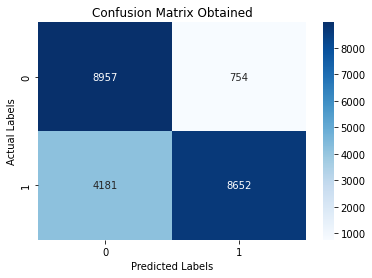

Accuarcy value obtained is  0.7811
F1-score obtained is  0.7781
Precision obtained is  0.9198
Recall obtained is  0.6742


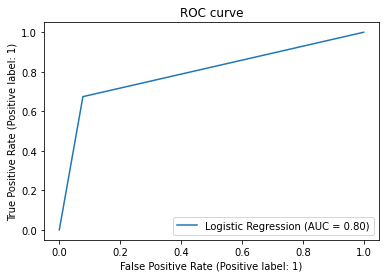

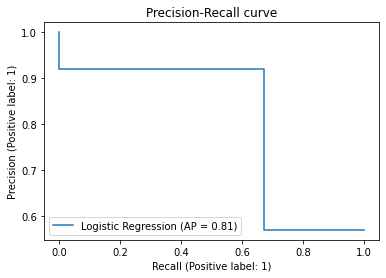

In [30]:
logreg = LogisticRegression(C=29.763514416313132, max_iter=1000, random_state=0, solver='liblinear')
logreg.fit(processed_train_data_trX,processed_train_data_trY)
logreg_yPred = logreg.predict(processed_test_data_X)
#Performance Metrics obtained using Logistic Regression
logreg_list = ["Logistic Regression after Hyperparameter Tuning"]
logreg_list.extend(print_metrics(processed_test_data_Y, logreg_yPred,"Logistic Regression"))
logreg_results_table.append(logreg_list)

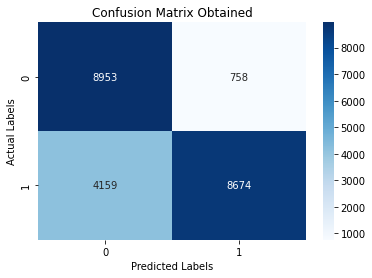

Accuarcy value obtained is  0.7819
F1-score obtained is  0.7792
Precision obtained is  0.9196
Recall obtained is  0.6759


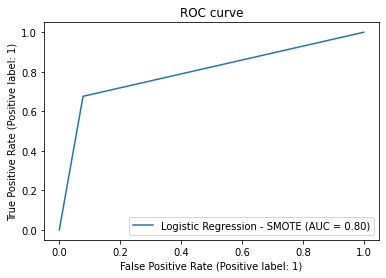

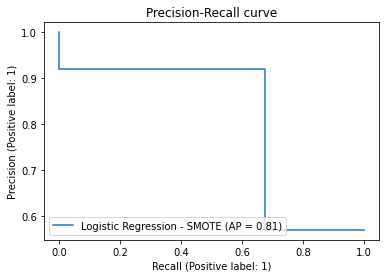

In [31]:
logreg_smote = LogisticRegression(C=4.281332398719396, max_iter=1000, penalty='l1', random_state=0, solver='liblinear')
logreg_smote.fit(processed_smote_train_data_trX,processed_smote_train_data_trY)
logreg_smote_yPred = logreg_smote.predict(processed_test_data_X)
#Performance Metrics obtained using Logistic Regression
logreg_list = ["Logistic Regression - SMOTE after Hyperparameter Tuning"]
logreg_list.extend(print_metrics(processed_test_data_Y, logreg_smote_yPred,"Logistic Regression - SMOTE"))
logreg_results_table.append(logreg_list)

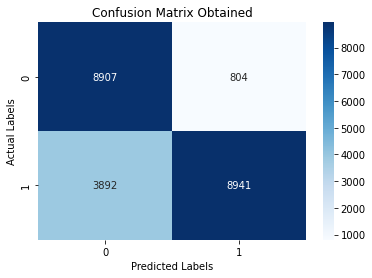

Accuarcy value obtained is  0.7917
F1-score obtained is  0.792
Precision obtained is  0.9175
Recall obtained is  0.6967


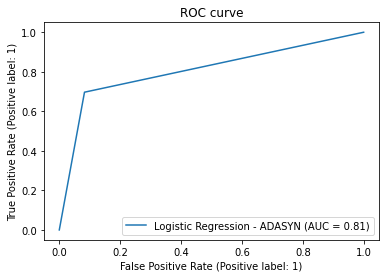

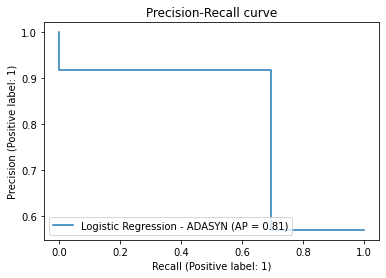

In [32]:
logreg_adasyn = LogisticRegression(C=0.012742749857031334, max_iter=1000, penalty='l1', random_state=0, solver='liblinear')
logreg_adasyn.fit(processed_adasyn_train_data_trX,processed_adasyn_train_data_trY)
logreg_adasyn_yPred = logreg_adasyn.predict(processed_test_data_X)
#Performance Metrics obtained using Logistic Regression
logreg_list = ["Logistic Regression - ADASYN after Hyperparameter Tuning"]
logreg_list.extend(print_metrics(processed_test_data_Y, logreg_adasyn_yPred,"Logistic Regression - ADASYN"))
logreg_results_table.append(logreg_list)

In [33]:
logreg_results_table

[['Logistic Regression', 0.7812, 0.7782, 0.92, 0.6744],
 ['Logistic Regression - SMOTE', 0.7816, 0.7788, 0.9198, 0.6753],
 ['Logistic Regression - ADASYN', 0.7925, 0.7928, 0.9182, 0.6975],
 ['Logistic Regression after Hyperparameter Tuning',
  0.7811,
  0.7781,
  0.9198,
  0.6742],
 ['Logistic Regression - SMOTE after Hyperparameter Tuning',
  0.7819,
  0.7792,
  0.9196,
  0.6759],
 ['Logistic Regression - ADASYN after Hyperparameter Tuning',
  0.7917,
  0.792,
  0.9175,
  0.6967]]

In [34]:
#Tabulating the obtained results and displaying the results by formatting
logreg_df = pd.DataFrame(logreg_results_table,columns = ["Classifier","accuracy","f1-score","Precision","Recall"])
with pd.option_context('display.precision', 4):
    formatted_table=(logreg_df.style.background_gradient(cmap ='RdYlGn'))
formatted_table

,Classifier,accuracy,f1-score,Precision,Recall
0,Logistic Regression,0.7812,0.7782,0.9200,0.6744
1,Logistic Regression - SMOTE,0.7816,0.7788,0.9198,0.6753
2,Logistic Regression - ADASYN,0.7925,0.7928,0.9182,0.6975
3,Logistic Regression after Hyperparameter Tuning,0.7811,0.7781,0.9198,0.6742
4,Logistic Regression - SMOTE after Hyperparameter Tuning,0.7819,0.7792,0.9196,0.6759
5,Logistic Regression - ADASYN after Hyperparameter Tuning,0.7917,0.7920,0.9175,0.6967


100%|██████████| 34/34 [01:33<00:00,  2.74s/it]


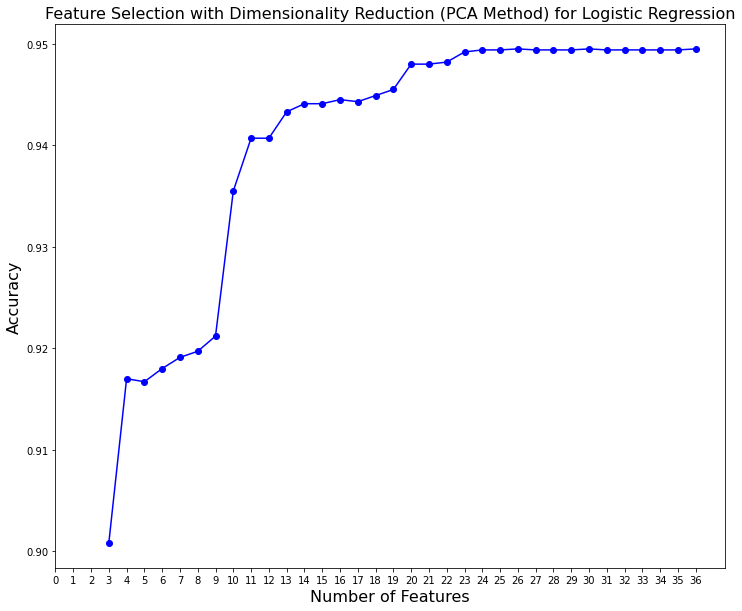

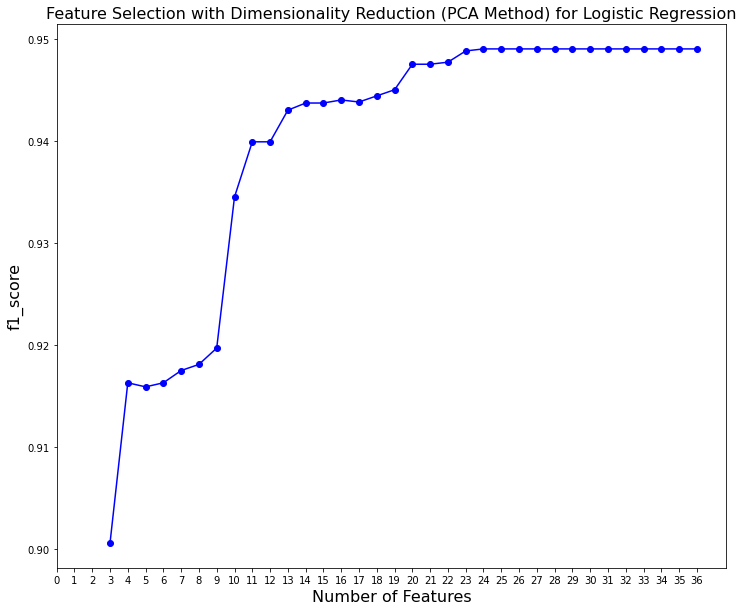

Logistic Regression Model - Maximum accuracy obtained using PCA is 0.9495 for the number of components = 26
Logistic Regression Model - Maximum f1-score obtained using PCA is 0.949 for the number of components = 24


In [35]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

logreg_adasyn = LogisticRegression(C=0.012742749857031334, max_iter=1000, penalty='l1', random_state=0, solver='liblinear')
acc_dict = {}
f1_dict = {}

for nf in tqdm(range(3,processed_adasyn_train_data_trX.shape[1]+1)):
    acc_val = []
    f1_val = []
    for train_index,test_index in skf.split(processed_adasyn_train_data_trX,processed_adasyn_train_data_trY):
        X_train, X_test = processed_adasyn_train_data_trX.iloc[train_index], processed_adasyn_train_data_trX.iloc[test_index]
        y_train, y_test = processed_adasyn_train_data_trY.iloc[train_index], processed_adasyn_train_data_trY.iloc[test_index]
        pca = PCA(n_components=nf,random_state=rs)
        pca_train = pca.fit_transform(X_train)
        logreg_adasyn.fit(pca_train,y_train)
        pca_test = pca.transform(X_test)
        pca_test_predict = logreg_adasyn.predict(pca_test)
        acc_val.append(round(accuracy_score(y_test, pca_test_predict),4))
        f1_val.append(round(f1_score(y_test,pca_test_predict,labels=np.unique(pca_test_predict)),4))
    acc_dict[nf] = round(sum(acc_val)/len(acc_val),4)
    f1_dict[nf] = round(sum(f1_val)/len(f1_val),4)
plt.figure(figsize=(12,10))
plt.plot(*zip(*sorted(acc_dict.items())),color='blue',marker='o')
Title = "Feature Selection with Dimensionality Reduction (PCA Method) for Logistic Regression"
plt.title(Title, fontsize=16)
plt.xticks(range(0,processed_adasyn_train_data_trX.shape[1]+1))
plt.xlabel("Number of Features", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.show();
plt.figure(figsize=(12,10))
plt.plot(*zip(*sorted(f1_dict.items())),color='blue',marker='o')
Title = "Feature Selection with Dimensionality Reduction (PCA Method) for Logistic Regression"
plt.title(Title, fontsize=16)
plt.xticks(range(0,processed_adasyn_train_data_trX.shape[1]+1))
plt.xlabel("Number of Features", fontsize=16)
plt.ylabel("f1_score", fontsize=16)
plt.show();
acc_adasyn_logreg = max(acc_dict.values())
acc_nfea_adasyn_logreg =  max(acc_dict, key=acc_dict.get)
f1_adasyn_logreg = max(f1_dict.values())
f1_nfea_adasyn_logreg =  max(f1_dict, key=f1_dict.get)
print("Logistic Regression Model - Maximum accuracy obtained using PCA is {} for the number of components = {}".format(acc_adasyn_logreg,acc_nfea_adasyn_logreg))
print("Logistic Regression Model - Maximum f1-score obtained using PCA is {} for the number of components = {}".format(f1_adasyn_logreg,f1_nfea_adasyn_logreg))

In [36]:
print(acc_dict[24],acc_dict[26])
print(f1_dict[24],f1_dict[26])

0.9494 0.9495
0.949 0.949


In [37]:
def utility_select_feature(processed_adasyn_train_data_trX, processed_adasyn_train_data_trY, fsm, model):
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    acc_val = []
    f1_val = []
    for train_index,test_index in skf.split(processed_adasyn_train_data_trX,processed_adasyn_train_data_trY):
        X_train, X_test = processed_adasyn_train_data_trX.iloc[train_index], processed_adasyn_train_data_trX.iloc[test_index]
        y_train, y_test = processed_adasyn_train_data_trY.iloc[train_index], processed_adasyn_train_data_trY.iloc[test_index]
        fs = fsm.fit(X_train, y_train)
        Xtrain_new = fs.transform(X_train)
        Xtest_new = fs.transform(X_test)
        model.fit(Xtrain_new, y_train)
        yPred = model.predict(Xtest_new)
        acc_val.append(round(accuracy_score(y_test, yPred),4))
        f1_val.append(round(f1_score(y_test,yPred,labels=np.unique(yPred)),4))
    acc = round(sum(acc_val)/len(acc_val),4)
    f1 = round(sum(f1_val)/len(f1_val),4)
    return acc,f1

100%|██████████| 34/34 [27:15<00:00, 48.12s/it]


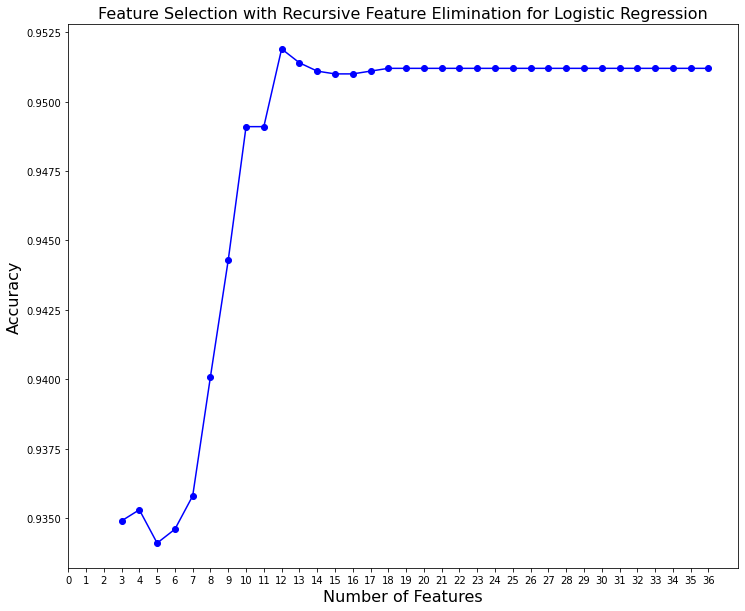

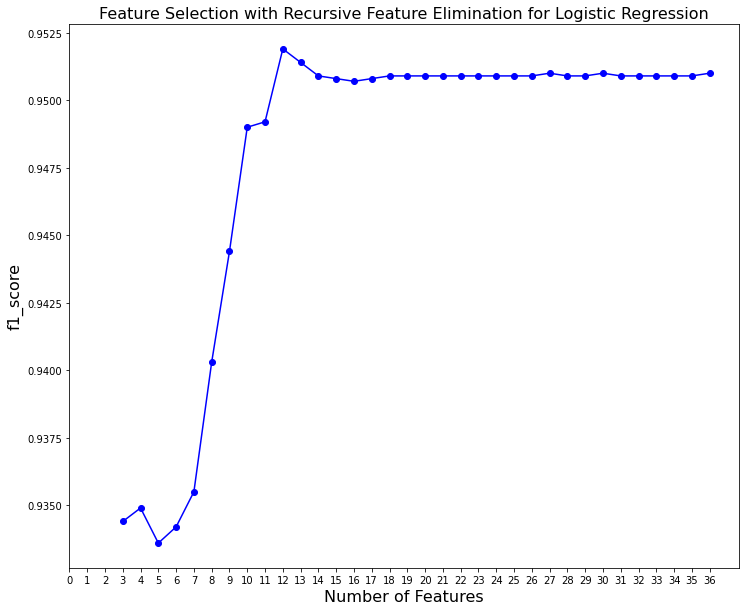

Logistic Regression Model - Maximum accuracy obtained using Recursive Feature Elimination Method 0.9519 for the number of features = 12
Logistic Regression Model - Maximum f1-score obtained using Recursive Feature Elimination Method 0.9519 for the number of features = 12


In [38]:
logreg = LogisticRegression(C=0.012742749857031334, max_iter=1000, penalty='l1', random_state=0, solver='liblinear')
acc_dict = {}
f1_dict ={}
for nf in tqdm(range(3,processed_adasyn_train_data_trX.shape[1]+1)):
    rfe = RFE(logreg, n_features_to_select=nf)
    acc,f1_val = utility_select_feature(processed_adasyn_train_data_trX, processed_adasyn_train_data_trY, rfe, logreg)
    acc_dict[nf] = acc
    f1_dict[nf] = f1_val

plt.figure(figsize=(12,10))
plt.plot(*zip(*sorted(acc_dict.items())),color='blue',marker='o')
Title = "Feature Selection with Recursive Feature Elimination for Logistic Regression"
plt.title(Title, fontsize=16)
plt.xticks(range(0,processed_adasyn_train_data_trX.shape[1]+1))
plt.xlabel("Number of Features", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.show();

plt.figure(figsize=(12,10))
plt.plot(*zip(*sorted(f1_dict.items())),color='blue',marker='o')
Title = "Feature Selection with Recursive Feature Elimination for Logistic Regression"
plt.title(Title, fontsize=16)
plt.xticks(range(0,processed_adasyn_train_data_trX.shape[1]+1))
plt.xlabel("Number of Features", fontsize=16)
plt.ylabel("f1_score", fontsize=16)
plt.show();

acc_adasyn_logreg = max(acc_dict.values())
acc_nfea_adasyn_logreg=  max(acc_dict, key=acc_dict.get)
f1_adasyn_logreg = max(f1_dict.values())
f1_nfea_adasyn_logreg=  max(f1_dict, key=f1_dict.get)
print("Logistic Regression Model - Maximum accuracy obtained using Recursive Feature Elimination Method {} for the number of features = {}".format(acc_adasyn_logreg,acc_nfea_adasyn_logreg))
print("Logistic Regression Model - Maximum f1-score obtained using Recursive Feature Elimination Method {} for the number of features = {}".format(f1_adasyn_logreg,f1_nfea_adasyn_logreg))

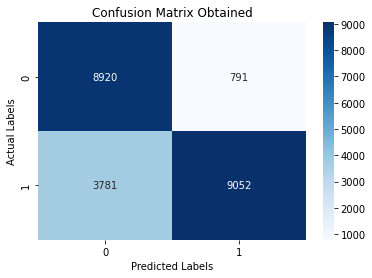

Accuarcy value obtained is  0.7972
F1-score obtained is  0.7984
Precision obtained is  0.9196
Recall obtained is  0.7054


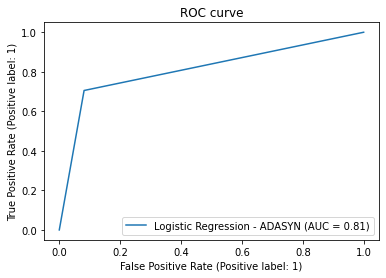

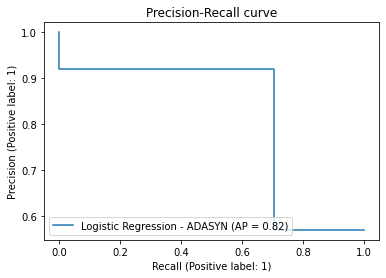

In [39]:
logreg = LogisticRegression(C=0.012742749857031334, max_iter=1000, penalty='l1', random_state=0, solver='liblinear')
adasyn = ADASYN(random_state=rs)
pca = PCA(n_components=26,random_state=rs)
logreg_pca_pipeline = Pipeline([('adasyn', adasyn), ('pca', pca), ('logreg', logreg)])
logreg_pca_pipeline.fit(processed_train_data_trX,processed_train_data_trY)
logreg_pca_pipeline_yPred = logreg_pca_pipeline.predict(processed_test_data_X)
logreg_list = ["Logistic Regression - ADASYN after Hyperparameter Tuning and Feature Selection based on PCA"]
logreg_list.extend(print_metrics(processed_test_data_Y, logreg_pca_pipeline_yPred,"Logistic Regression - ADASYN"))
logreg_results_table.append(logreg_list)

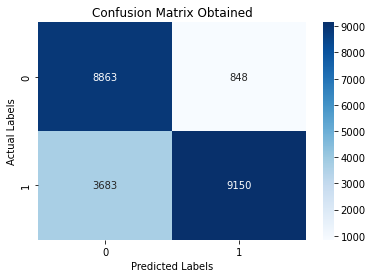

Accuarcy value obtained is  0.799
F1-score obtained is  0.8015
Precision obtained is  0.9152
Recall obtained is  0.713


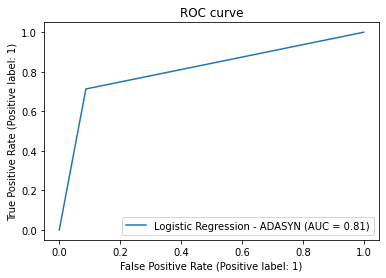

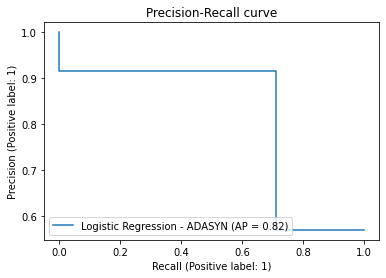

In [40]:
logreg = LogisticRegression(C=0.012742749857031334, max_iter=1000, penalty='l1', random_state=0, solver='liblinear')
adasyn = ADASYN(random_state=rs)
rfe = RFE(logreg, n_features_to_select=12)
logreg_rfe_pipeline = Pipeline([('adasyn', adasyn), ('rfe', rfe), ('logreg', logreg)])
logreg_rfe_pipeline.fit(processed_train_data_trX,processed_train_data_trY)
logreg_rfe_pipeline_yPred = logreg_rfe_pipeline.predict(processed_test_data_X)
logreg_list = ["Logistic Regression - ADASYN after Hyperparameter Tuning and Feature Selection based on Recursive Feature Elimination"]
logreg_list.extend(print_metrics(processed_test_data_Y, logreg_rfe_pipeline_yPred,"Logistic Regression - ADASYN"))
logreg_results_table.append(logreg_list)

In [41]:
logreg_results_table

[['Logistic Regression', 0.7812, 0.7782, 0.92, 0.6744],
 ['Logistic Regression - SMOTE', 0.7816, 0.7788, 0.9198, 0.6753],
 ['Logistic Regression - ADASYN', 0.7925, 0.7928, 0.9182, 0.6975],
 ['Logistic Regression after Hyperparameter Tuning',
  0.7811,
  0.7781,
  0.9198,
  0.6742],
 ['Logistic Regression - SMOTE after Hyperparameter Tuning',
  0.7819,
  0.7792,
  0.9196,
  0.6759],
 ['Logistic Regression - ADASYN after Hyperparameter Tuning',
  0.7917,
  0.792,
  0.9175,
  0.6967],
 ['Logistic Regression - ADASYN after Hyperparameter Tuning and Feature Selection based on PCA',
  0.7972,
  0.7984,
  0.9196,
  0.7054],
 ['Logistic Regression - ADASYN after Hyperparameter Tuning and Feature Selection based on Recursive Feature Elimination',
  0.799,
  0.8015,
  0.9152,
  0.713]]

In [42]:
#Tabulating the obtained results and displaying the results by formatting
logreg_df = pd.DataFrame(logreg_results_table, columns = ["Classifier","accuracy","f1-score","Precision","Recall"])
with pd.option_context('display.precision', 4):
    formatted_table=(logreg_df.style.background_gradient(cmap ='RdYlGn'))
formatted_table

,Classifier,accuracy,f1-score,Precision,Recall
0,Logistic Regression,0.7812,0.7782,0.9200,0.6744
1,Logistic Regression - SMOTE,0.7816,0.7788,0.9198,0.6753
2,Logistic Regression - ADASYN,0.7925,0.7928,0.9182,0.6975
3,Logistic Regression after Hyperparameter Tuning,0.7811,0.7781,0.9198,0.6742
4,Logistic Regression - SMOTE after Hyperparameter Tuning,0.7819,0.7792,0.9196,0.6759
5,Logistic Regression - ADASYN after Hyperparameter Tuning,0.7917,0.7920,0.9175,0.6967
6,Logistic Regression - ADASYN after Hyperparameter Tuning and Feature Selection based on PCA,0.7972,0.7984,0.9196,0.7054
7,Logistic Regression - ADASYN after Hyperparameter Tuning and Feature Selection based on Recursive Feature Elimination,0.7990,0.8015,0.9152,0.7130


In [43]:
logreg_df = logreg_df.set_index("Classifier")

In [44]:
with pd.option_context('display.precision', 4):
    formatted_table=(logreg_df.style.background_gradient(cmap ='RdYlGn'))
formatted_table

,accuracy,f1-score,Precision,Recall
Classifier,,,,
Logistic Regression,0.7812,0.7782,0.9200,0.6744
Logistic Regression - SMOTE,0.7816,0.7788,0.9198,0.6753
Logistic Regression - ADASYN,0.7925,0.7928,0.9182,0.6975
Logistic Regression after Hyperparameter Tuning,0.7811,0.7781,0.9198,0.6742
Logistic Regression - SMOTE after Hyperparameter Tuning,0.7819,0.7792,0.9196,0.6759
Logistic Regression - ADASYN after Hyperparameter Tuning,0.7917,0.7920,0.9175,0.6967
Logistic Regression - ADASYN after Hyperparameter Tuning and Feature Selection based on PCA,0.7972,0.7984,0.9196,0.7054
Logistic Regression - ADASYN after Hyperparameter Tuning and Feature Selection based on Recursive Feature Elimination,0.7990,0.8015,0.9152,0.7130
